>     Instructions for the execution of the code:
>     
>     - We suppose to work with an existing directory with path "/content/gdrive/MyDrive/NLU_project/", 
>       containing a folder "dataset" with the zipped dataset ptbdataset.zip (at "dataset/ptbdataset.zip") and an empty folder "models". 
>     - The code cells should be executed one after the other, in the same order in which they appear. 
>       Otherwise some errors may arise in the execution.

#<center> Language Modeling </center>
###### <center> with </center>
#<center> LSTM and Attention </center>
---

-       Imports and global variables

In [1]:
# Imports
import os
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.utils.data as data
import torch.optim as optim
from collections import Counter
import nltk


# Seeds
torch.manual_seed(5)
random.seed(5)
np.random.seed(5)

# Global variables
device = 'cuda:0' 
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
PAD_TOKEN = 0

-       Mounting of the Google Drive folder

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive



<br/>

## <center>Analysis of the Penn Tree bank dataset:</center>
This section contains all the operations performed on the dataset with the aims of:
-     extracting all the training, test and validation sentences
-     constructing a vocabulary and a map from words to indexes (and viceversa)
-     analyzing the properties of the dataset. 

In [ ]:
!unzip gdrive/MyDrive/NLU_project/dataset/ptbdataset.zip -d gdrive/MyDrive/NLU_project/dataset


<br/>

### Extraction of the sentences and the words from the dataset

The dataset consists in three .txt files, corresponding to training, validation and test sets, each of them containing sentences, distinguished from being in different line of the file.

In [3]:
"""
Function that returns all the sentences in the txt from the input path.

:param path: path to the txt dataset
:return sents: list of all sentences
"""

def list_sents(path):
    sents = []
    with open(path) as file:
        for line in file:
          sent = line.split()
          sents.append(sent)
    file.close()
    return sents

"""
Function that returns all the words in the txt of the input path.

:param path: path to the txt dataset
:return sents: set of all words
"""
def list_words(path):
    words = []
    with open(path) as file:
        for line in file:
          for word in line.split():
            words.append(word)
    file.close()
    return words

*  Extraction of sentences from the dataset, seen as lists of words.

In [4]:
# Sentences in the training set 
train_sents = list_sents("gdrive/MyDrive/NLU_project/dataset/ptb.train.txt")

# Sentences in the test set 
test_sents = list_sents("gdrive/MyDrive/NLU_project/dataset/ptb.test.txt")

# Sentences in the validation set 
valid_sents = list_sents("gdrive/MyDrive/NLU_project/dataset/ptb.valid.txt")

*    Extraction of the list (and set) of words from the dataset.

In [5]:
# Words in the training set 
train_words_list = list_words("gdrive/MyDrive/NLU_project/dataset/ptb.train.txt")
train_words = set(train_words_list)

# Words in the test set 
test_words_list = list_words("gdrive/MyDrive/NLU_project/dataset/ptb.test.txt")
test_words = set(test_words_list)

# Words in the validation set 
valid_words_list = list_words("gdrive/MyDrive/NLU_project/dataset/ptb.valid.txt")
valid_words = set(valid_words_list)


<br/>

At this point some considerations can be made about the dataset, that are useful for the preprocessing as well as for the setting of the training procedure:

-      all the words it contains are already **lowercased**
-      it does not contain puctuation
-      all the numbers have been replaced with the symbol "**N**"
-      the training set, as well as the test and validation set, contain the special token **\<unk\>**. This means that this dataset has already been preprocessed and that the \<unk\> token is already applied in the corpus, because the maximum vocabulary size was previously fixed to **10k words**.


In [6]:
# The <unk> token is already contained
print('<unk>' in train_words)

# The numbers are replaced with N
print('N' in train_words)

True
True



<br/>

Another property that must be checked is the maximum length of the sentences in the training set. Indeed, since the Language Model is implemented through an RNN architecture, it's important to make sure the training sequences are not excessively long, otherwise the simple Backpropagation Through Time may suffer of vanishing or exploding gradients and a more sophisticated approach (Truncated BBTT) should be adopted to reduce the problem.

It's easily verified that the maximum length of the sentences in the training set is 82. This guarantees that Backpropagation Through Time can be adopted without too serious consequences in the following steps.

Also, the length of each sequence in **train_sents** is at least 1. Indeed, it is possibile to verify that none of the sentences has length 0 (which means that there are no empty lines in the .txt file), while many of them have length 1, and they correspond to sentences composed by one single word.

In [7]:
# The sequences with length values over 80 are few
print("Maximum length reached in training set: ")
max_len = -1
for sent in train_sents:
  if len(sent) > max_len:
    max_len = len(sent)
print(max_len)

# The sequences with length values equal to 1 are a lot
print("\nNumber of sentences with length equal to 1 in training set: ")
sent_equal_1 = 0
for sent in train_sents:
  if len(sent) == 1:
    sent_equal_1 += 1
print(sent_equal_1)

# There are no sequences of length 0
print("\nNumber of sentences with length equal to 0 in training set: ")
sent_equal_0 = 0
for sent in train_sents:
  if len(sent) == 0:
    sent_equal_0 += 1
print(sent_equal_0)

Maximum length reached in training set: 
82

Number of sentences with length equal to 1 in training set: 
137

Number of sentences with length equal to 0 in training set: 
0



<br/>

The same type of statistical analysis can be performed also on the validation and test sets. This can be useful to predict in advance, to some extent, whether the methods and techniques adopted for the training phase will work well also in the validation and test phases.

In [8]:
# Length of sequences in test and validation sets, for statistical purposes

print("Maximum length in validation set:")
max_len = -1
for sent in valid_sents:
  if len(sent) > max_len:
    max_len = len(sent)
print(max_len)

print("\n")

print("Maximum length in test set:")
max_len = -1
for sent in test_sents:
  if len(sent) > max_len:
    max_len = len(sent)
print(max_len)

Maximum length in validation set:
74


Maximum length in test set:
77



<br/>

It may be interesting to plot the histograms that show graphically the frequencies of the various sequence lengths, from the minimal of 0 to the maximal one (defined according to the results previously obtained for the three cases). 

The obtained graphs, that follow a "bell curve" shape, clearly show that in all cases the **most frequent sequence length** corresponds to a value **between 15 and 20**, and **most sentences** are characterized by a length value that is **below 25**.

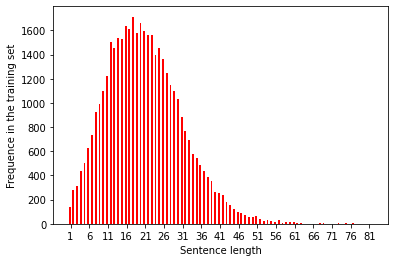

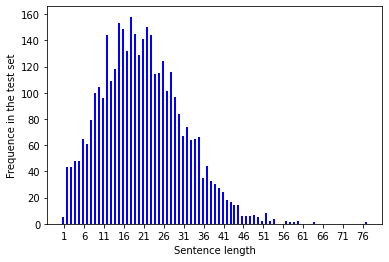

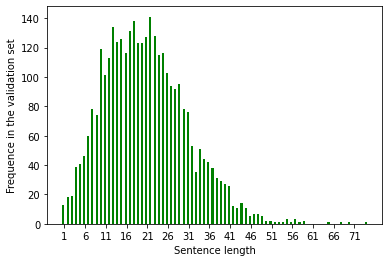

In [10]:
# Training set 

lengths = list(range(1, 83))
frequencies = [0 for i in lengths]
for sent in train_sents:
  frequencies[len(sent)-1] += 1

pos = np.arange(1, 86, 5)
width = 0.5  
lens = list(range(1, 86, 5))

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(lens)
ax.set_xlabel(r'Sentence length')
ax.set_ylabel(r'Frequence in the training set')

plt.bar(lengths, frequencies, width, color='r')
plt.show()

# Test set

lengths = list(range(1, 78))
frequencies = [0 for i in lengths]
for sent in test_sents:
  frequencies[len(sent)-1] += 1

pos = np.arange(1, 81, 5)
width = 0.5  
lens = list(range(1, 81, 5))

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(lens)
ax.set_xlabel(r'Sentence length')
ax.set_ylabel(r'Frequence in the test set')

plt.bar(lengths, frequencies, width, color='b')
plt.show()


# Validation set 

lengths = list(range(1, 75))
frequencies = [0 for i in lengths]
for sent in valid_sents:
  frequencies[len(sent)-1] += 1

pos = np.arange(1, 76, 5)
width = 0.5  
lens = list(range(1, 76, 5))

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(lens)
ax.set_xlabel(r'Sentence length')
ax.set_ylabel(r'Frequence in the validation set')

plt.bar(lengths, frequencies, width, color='g')
plt.show()


<br/>


A fundamental value that must be taken into account for the definition of the capacity (and hence the number of parameters/layers/units of the model) is the **dimension of the training set**. The more samples are contained in the training set, the easiest it is to avoid overfitting (with properly adopted regularization methods), while maintaining a fixed number of parameters in the architectural framework. 

In [11]:
# Number of samples in the training set
print("Train: ", len(train_sents), "\n")

# Number of samples in the test set
print("Test: ", len(test_sents), "\n")

# Number of samples in the validation set
print("Valid: ", len(valid_sents), "\n")

Train:  42068 

Test:  3761 

Valid:  3370 




<br/>



Additionally to the aforementioned points, it's important to notice that **there are no OOV words** in the test and validation sets, that is, all the words belonging to the test and validation sets already belong to the training set. 

This implies that, in order to define a reference vocabulary, it suffices to **consider just the words contained in the training set**.

The total number of words contained in the training set is **9999**.

In [12]:
print("Test words set is contained in training words set: ") 
print(test_words.issubset(train_words), "\n")

print("Validation words set is contained in training words set : ")
print(valid_words.issubset(train_words), "\n")

# Number of words in the training set
print("Total number of words in the training set: ", len(train_words))


Test words set is contained in training words set: 
True 

Validation words set is contained in training words set : 
True 

Total number of words in the training set:  9999



<br/>


The **50 most frequent words** for the tree sets of the dataset are now computed. 

It is possible to notice that, along with the most common prepositions, such as "the" and "of", the special tokens **"N"** and "**\<unk\>**" correspond to the words that appear most frequently.

In [13]:
# Training set 

training_freqdist = nltk.FreqDist(train_words_list)
print("First 50 words of the training Frequency Dictionary: ")
print(dict(sorted(training_freqdist.items(), key=lambda item: item[1], reverse=True)[:50]), '\n')

# Test set 

test_freqdist = nltk.FreqDist(test_words_list)
print("First 50 words of the test Frequency Dictionary: ")
print(dict(sorted(test_freqdist.items(), key=lambda item: item[1], reverse=True)[:50]), '\n')

# Validation set 

valid_freqdist = nltk.FreqDist(valid_words_list)
print("First 50 words of the validation Frequency Dictionary: ")
print(dict(sorted(valid_freqdist.items(), key=lambda item: item[1], reverse=True)[:50]), '\n')

First 50 words of the training Frequency Dictionary: 
{'the': 50770, '<unk>': 45020, 'N': 32481, 'of': 24400, 'to': 23638, 'a': 21196, 'in': 18000, 'and': 17474, "'s": 9784, 'that': 8931, 'for': 8927, '$': 7541, 'is': 7337, 'it': 6112, 'said': 6027, 'on': 5650, 'by': 4915, 'at': 4894, 'as': 4833, 'from': 4724, 'million': 4627, 'with': 4585, 'mr.': 4326, 'was': 4073, 'be': 3923, 'are': 3914, 'its': 3846, 'he': 3632, 'but': 3541, 'has': 3494, 'an': 3477, "n't": 3388, 'will': 3270, 'have': 3245, 'new': 2793, 'or': 2704, 'company': 2680, 'they': 2562, 'this': 2438, 'year': 2379, 'which': 2362, 'would': 2308, 'about': 2220, 'says': 2092, 'more': 2065, 'were': 2009, 'market': 2005, 'billion': 1881, 'his': 1852, 'had': 1850} 

First 50 words of the test Frequency Dictionary: 
{'<unk>': 4794, 'the': 4529, 'N': 2523, 'of': 2195, 'to': 2042, 'a': 1821, 'in': 1640, 'and': 1539, "'s": 903, 'that': 831, 'for': 783, 'is': 667, 'said': 601, '$': 564, 'it': 542, 'on': 507, 'as': 461, 'by': 450, 'at': 


<br/>

### Definition of the vocabulary

The vocabulary is defined as an instance of the class **Vocab**, and it is composed by two dictionaries that map each word from the dataset to a particular index and viceversa.

As mentioned before, it suffices to consider the words contained in the training set, since it contains also all the words from the test and validation sets. Additionally to these ones, the dictionary also contains two special tokens:

*  **'pad'**, that is the padding token (which is defined as "0"), that will be useful for constructing the batches in the following steps;
*  **'\</s\>'**, the end-of-sentence token, which is added at the end of each sentence of the datasets before the construction of the batches. 


In [6]:
class Vocab():

    def __init__(self, words):
        self.word2id = self.w2id(words)
        self.id2word = {v:k for k, v in self.word2id.items()}
        
    def w2id(self, elements):
        vocab = {'pad': PAD_TOKEN, '</s>': 1}
        for w in list(elements):
          if w not in vocab:
            vocab[w] = len(vocab)
        return vocab


# Creation of the vocabulary containing all the words in training, test and validation sets
vocab = Vocab(train_words_list)


<br/>

The dimension of the two dictionaries is hence 9999 + 1 + 1 = **10001**.

In [15]:
print(len(vocab.id2word))
print(len(vocab.word2id))

10001
10001



<br/>

## <center>First baseline: N-gram statistical language models</center>

In order to better evaluate the results that will be obtained through the Neural Language Model, a statistical baseline is implemented through three **n-gram Language Models** and considered as a starting point reference.

In [ ]:
# Preparation of test data 

from nltk.lm.preprocessing import pad_both_ends

test_sentences_padding_2 = [w for sent in test_sents for w in list(pad_both_ends(sent, n=2))]
test_sentences_padding_3 = [w for sent in test_sents for w in list(pad_both_ends(sent, n=3))]

test_ngrams_padding = {}
test_ngrams_padding[2] = list(nltk.bigrams(test_sentences_padding_2))
test_ngrams_padding[3] = list(nltk.trigrams(test_sentences_padding_3))

Training and evaluation of 2-gram and 3-gram Language Models:

* MLE
* Laplace
* Lidstone

It is possible to verify that the result are not outstanding, and the **bigram** Language Models (~ 900 in test perplexity) behave better with respect to the **trigram** Language Models (~ 3000 in test perplexity) in this setting.

In [ ]:
from nltk.lm.preprocessing import padded_everygram_pipeline

from nltk.lm import MLE, Laplace, Lidstone

print("MLE: \n")

for ngram_size in [2,3]:

    print("n-gram size: ", ngram_size, "\n")
    
    # Preparation of training data
    padded_ngrams, flat_text = list(padded_everygram_pipeline(ngram_size, train_sents))
    
    mle_lm = MLE(ngram_size)
    mle_lm.fit(padded_ngrams, flat_text)
    print("MLE ngram counts: ", mle_lm.counts)
    print("MLE entropy: ", mle_lm.entropy(test_ngrams_padding[ngram_size]))
    print("MLE perplexity: ", mle_lm.perplexity(test_ngrams_padding[ngram_size]))
    print("\n")


print("Laplace: \n")

for ngram_size in [2,3]:

    print("n-gram size: ", ngram_size, "\n")
    
    padded_ngrams, flat_text = list(padded_everygram_pipeline(ngram_size, train_sents))
    
    # 1) Laplace
    laplace_lm = Laplace(ngram_size)
    laplace_lm.fit(padded_ngrams, flat_text)
    print("Laplace ngram counts: ", laplace_lm.counts)
    print("Laplace entropy: ", laplace_lm.entropy(test_ngrams_padding[ngram_size]))
    print("Laplace perplexity: ", laplace_lm.perplexity(test_ngrams_padding[ngram_size]))
    print("\n")


print("Lidstone: \n")

for ngram_size in [2,3]:

    print("n-gram size: ", ngram_size, "\n")

    padded_ngrams, flat_text = list(padded_everygram_pipeline(ngram_size, train_sents))
    
    # 2) Lidstone
    # also requires gamma parameter
    lidstone_lm = Lidstone(order=ngram_size, gamma=1)
    lidstone_lm.fit(padded_ngrams, flat_text)
    print("Lidstone ngram counts: ", lidstone_lm.counts)
    print("Lidstone entropy: ", lidstone_lm.entropy(test_ngrams_padding[ngram_size]))
    print("Lidstone perplexity: ", lidstone_lm.perplexity(test_ngrams_padding[ngram_size]))
    print("\n")

MLE: 

n-gram size:  2 

MLE ngram counts:  <NgramCounter with 2 ngram orders and 1901246 ngrams>
MLE entropy:  inf
MLE perplexity:  inf


n-gram size:  3 

MLE ngram counts:  <NgramCounter with 3 ngram orders and 3041175 ngrams>
MLE entropy:  inf
MLE perplexity:  inf


Laplace: 

n-gram size:  2 

Laplace ngram counts:  <NgramCounter with 2 ngram orders and 1901246 ngrams>
Laplace entropy:  9.843858866753022
Laplace perplexity:  918.9603891637692


n-gram size:  3 

Laplace ngram counts:  <NgramCounter with 3 ngram orders and 3041175 ngrams>
Laplace entropy:  11.667129359774286
Laplace perplexity:  3252.0401633846063


Lidstone: 

n-gram size:  2 

Lidstone ngram counts:  <NgramCounter with 2 ngram orders and 1901246 ngrams>
Lidstone entropy:  9.843858866753022
Lidstone perplexity:  918.9603891637692


n-gram size:  3 

Lidstone ngram counts:  <NgramCounter with 3 ngram orders and 3041175 ngrams>
Lidstone entropy:  11.667129359774286
Lidstone perplexity:  3252.0401633846063





<br/>

## <center>Dataset and Dataloader</center>

The code used for the definition of the datasets and dataloaders was inspired and adapted from the *10_sequence_nn.ipynb* Notebook explained during the lectures of the course.

In [7]:
"""
Function that returns all the sentences in the txt from the input path, 
with the addition of the end-of-sequence token </s>.

:param path: path to the txt dataset
:return sents: list of all sentences, each one ending with </s>
"""
def list_sents_eos(path):
    sents = []
    with open(path) as file:
        for line in file:
          sent = line.split()
          sent.insert(len(sent), '</s>')
          sents.append(sent)
    file.close()
    return sents

# Sentences in the training set, with the end-of-sentence token </s>
train_data = list_sents_eos("gdrive/MyDrive/NLU_project/dataset/ptb.train.txt")

# Sentences in the test set, with the end-of-sentence token </s>
test_data = list_sents_eos("gdrive/MyDrive/NLU_project/dataset/ptb.test.txt")

# Sentences in the validation set, with the end-of-sentence token </s>
valid_data = list_sents_eos("gdrive/MyDrive/NLU_project/dataset/ptb.valid.txt")


<br/>

### Definition of the datasets

The datasets are defined as instances of the class **SentsDataset**, and their elements are tensors, each one corresponding to a particular sentence, containing the numerical indexes to which each original word is mapped through the **vocab** dictionary maps.

In [8]:
class SentsDataset(data.Dataset):

    def __init__(self, dataset, vocab):
        self.sentences = dataset
        self.sents_ids = self.mapping_seq(self.sentences, vocab.word2id)

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sent = torch.Tensor(self.sents_ids[idx])
        return sent
    
    # Auxiliary method
    def mapping_seq(self, data, mapper): # Map sequences to number
        res = []
        for seq in data:
            tmp_seq = []
            for x in seq:
                tmp_seq.append(mapper[x])
            res.append(tmp_seq)
        return res


# Training dataset
train_dataset = SentsDataset(train_data, vocab)

# Validation dataset
valid_dataset = SentsDataset(valid_data, vocab)

# Test dataset
test_dataset = SentsDataset(test_data, vocab)


<br/>

### Definition of the dataloaders

The **Dataloader** class is needed in order to split the data into batches and add padding. Padding is a strategy used to fit sequences of different lengths into a matrix.
 
```python
DataLoader(Dataset, batch_size=N, collate_fn={custom function}, shuffle=True)
```

The Dataloader provides batches containing all the same number of sentences, and the batch size is fixed when the Dataloader is first defined. For what concerns the second dimension, it can vary from batch to batch and it corresponds to the **length of the longest sentence in the batch** itself. 
The sentences within a single batch are ordered according to their length, from the longest one to the shortest, and padding is performed through the **'pad'** token on the right of the sentences whose length is lower than **max_len**.

In order to customize the shape and composition of the output, an appropriate *collate_fn* function is defined. 

In [9]:
def collate_fn(sents):

    def merge(sequences):
        """
        Function used to merge from batch * sent_len to batch * max_len
        """
        lengths = [len(seq) for seq in sequences]
        max_len = 1 if max(lengths)==0 else max(lengths)
        padded_seqs = torch.LongTensor(len(sequences),max_len).fill_(PAD_TOKEN)
        # The matrix is filled with PAD_TOKENS 
        # And then each sentence is copied into the matrix
        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq # We copy each sequence into the matrix
        padded_seqs = padded_seqs.detach()  # We remove these tensors from the computational graph

        return padded_seqs, lengths

    # Sort data by seq lengths
    sents.sort(key=lambda s: len(s), reverse=True) 

    # Input sequences
    sents_in = [s[:-1] for s in sents]
    # Output (target) sequences
    sents_out = [s[1:] for s in sents]

    # The sequence length is the same in both cases
    padded_in, seq_lengths = merge(sents_in)
    padded_out, _ = merge(sents_out)

    # Length of input/output
    seq_lengths = torch.LongTensor(seq_lengths).to(device)

    return (padded_in, padded_out, seq_lengths)

The **batch_size** is set to **64** for both the training and evaluation phases. This value has shown to work well empirically for the considered task: it allows for a both fast and stable training procedure.

In [10]:
# Definition of the dataloaders
batch_size = 64

# Training dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn,  shuffle=True)

# Validation dataloader
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate_fn)

# Test dataloader
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)


<br/>

## <center>Baseline Neural Models</center>


<br/>

### Definition of the baseline models

Two baseline **Neural Language Models** are defined and evaluated: a simple RNN architecture with a Vanilla RNN cell, and the same architecture with an LSTM cell in substitution of the Vanilla cell. 
The LSTM provides some improvements in the training phase with respect to the simple Vanilla cell, since it allows to significantly reduce the issue of **vanishing and exploding gradients**, that make the training slower and more difficult. 

They are composed of the following modules:

* **Simple RNN**: 
    -   embedding layer 
    -   vanilla RNN cell 
    -   linear decoder layer 
* **LSTM**:  
    -   embedding layer 
    -   LSTM cell 
    -   linear decoder layer 


In [17]:
class Baseline_NLM(nn.Module):

    def __init__(self, hid_size, emb_size, vocab_len, lstm = False, n_layer = 1, pad_index = 0):

        super(Baseline_NLM, self).__init__()  

        # Word embedding 
        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        
        if lstm:
          # We set bidirectionality to false, so the LSTM is one-directional 
          self.rnn = nn.LSTM(emb_size, hid_size, n_layer, bidirectional=False) 
        else:
          self.rnn = nn.RNN(emb_size, hid_size, n_layer)   

        # Output layer
        self.decoder = nn.Linear(hid_size, vocab_len)
        
    def forward(self, sentences, seq_lengths):

        # sentences: (batch_size, seq_len)
        sents_emb = self.embedding(sentences) 
        # sents_emb: (batch_size, seq_len, emb_size)

        # Swap the matrix in order to have dimensions setted in another way:
        # We need seq len first -> permute
        sents_emb = sents_emb.permute(1,0,2) 
        # sents_emb: (seq_len, batch_size, emb_size)
        
        # Compression
        # pack_padded_sequence avoids computation over pad tokens reducing the computational cost
        packed_input = pack_padded_sequence(sents_emb, seq_lengths.cpu().numpy())

        # Process the batch through the RNN layer
        packed_output, _ = self.rnn(packed_input) 

        # Unpack the sequence: decompression
        padded_output, _ = pad_packed_sequence(packed_output)

        # Get the output
        out = self.decoder(padded_output)

        # Swap the output in order to have dimensions setted correctly for the loss
        out = out.permute(1,0,2).contiguous()
        out = out.view(-1, out.shape[-1])
        # out: (batch_size * seq_len, vocab_len)

        return out


<br/>

### Function to randomly initialize the weights of the architecture

Weight initialization is an essential procedure that allows to stabilize the training phase. 

In [11]:
def init_weights(mat):
    for m in mat.modules():
        if type(m) in [nn.LSTM, nn.RNN]:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.xavier_uniform_(param[idx*mul:(idx+1)*mul])
                elif 'weight_hh' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.orthogonal_(param[idx*mul:(idx+1)*mul])
                elif 'bias' in name:
                    param.data.fill_(0.00)
        else:
            if type(m) in [nn.Linear]:
                torch.nn.init.uniform_(m.weight, -0.1, 0.1)
                if m.bias != None:
                    m.bias.data.fill_(0.01)
            if type(m) in [nn.Embedding]:
                torch.nn.init.uniform_(m.weight, -0.1, 0.1)


<br/>

### Training loop

In [18]:
def train_loop_baseline(data_loader, optimizer, cost_function, model, device = 'cuda:0'):

    # Set the model in training mode
    model.train()

    # Cumulative loss values obtained for each batch
    loss_sum_array = []

    # Total number of words in the batch
    num_words_array = []

    # Iterate over the training set
    for batch_idx, (inputs, targets, lengths) in enumerate(data_loader):

        # Load data into GPU
        inputs = inputs.to(device)
        targets = targets.to(device)
          
        # Gradients reset
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs, lengths)

        # Loss computation
        loss = cost_function(outputs,targets.view(-1))

        # Update of the loss array and number of words array
        loss_sum_array.append(loss.item())
        num_words_array.append((torch.sum(lengths)).item())

        # Backward pass
        loss.backward()
        
        # Parameters update
        optimizer.step()
      
    return loss_sum_array, num_words_array


<br/>

### Evaluation loop

In [19]:
def eval_loop_baseline(data_loader, cost_function, model, device = 'cuda:0'):

  # Set the network to evaluation mode
  model.eval() 

  # Cumulative loss values obtained for each batch
  loss_sum_array = []

  # Total number of words in the batch
  num_words_array = []

  # Disable gradient computation 
  with torch.no_grad():

    # Iterate over the test set
    for batch_idx, (inputs, targets, lengths) in enumerate(data_loader):
      
        # Load data into GPU
        inputs = inputs.to(device)
        targets = targets.to(device)
          
        # Forward pass
        outputs = model(inputs, lengths)

        # Loss computation
        loss = cost_function(outputs, targets.view(-1))

        # Update of the loss array
        loss_sum_array.append(loss.item())
        num_words_array.append((torch.sum(lengths)).item())
      
  return loss_sum_array, num_words_array


<br/>

### Definition of the training procedure

The neural networks are trained by iterating several times (that is, for several **epochs**) over the training set.

The number of **epochs** defines the number of times the whole training set is seen by the network, and this quantity was set to a maximum fixed value of **200**. Indeed, it is most likely that less than 200 epochs are performed in practice, since an **early stopping** procedure is applied. 

**Early stopping** is a regularization technique that allows to save the network and stop the training procedure before the models overfits too much and the generalization gap starts being excessive. It is put in place by monitoring the **validation loss** (that is the loss computed on the validation set) every few steps, and stopping the training procedure when such loss is not subject to any improvement for a number of iterations equal to a certain fixed value called **patience**. So this value tells how many steps of not improving performance one has to wait before stopping the training. 

A **patience** value that has shown to work well in practice is **3**.
In order to put in place the early stopping procedure, the **validation set** is used.

In [20]:
def main_baseline(baseline_model,
         prediction_loss, 
         optimizer, 
         train_loader, 
         valid_loader, 
         test_loader,
         n_epochs = 200,   
         patience = 3):

    # Vectors filled during training that allow to plot the loss variations across epochs
    losses_train_baseline = []
    losses_valid_baseline = []
    sampled_epochs_baseline = []

    # Initial best loss value, used for the early stopping technique
    best_loss = 100.00


    for x in tqdm(range(n_epochs)):

        # For each epoch:
        print('Epoch n. ', x, '\n')

        """ Cross entropy loss and perplexity on the training set """
        loss_train, num_words = train_loop_baseline(train_loader, optimizer, prediction_loss, baseline_model)

        # Cross entropy
        ce_train = np.asarray(loss_train).sum() / np.asarray(num_words).sum()
        print('CE on the training set: ', ce_train, '\n')

        # Perplexity
        perplexity_train = np.exp(ce_train)
        print('Perplexity on the training set: ', perplexity_train, '\n')

        if x % 3 == 0:

            sampled_epochs_baseline.append(x)
            losses_train_baseline.append(ce_train)

            """ Cross entropy loss and perplexity on the validation set """
            loss_valid, num_words = eval_loop_baseline(valid_loader, prediction_loss, baseline_model)

            # Cross entropy
            ce_valid = np.asarray(loss_valid).sum() / np.asarray(num_words).sum()
            print('CE on the validation set: ', ce_valid, '\n')

            # Perplexity
            perplexity_valid = np.exp(ce_valid)
            print('Perplexity on the validation set: ', perplexity_valid, '\n')

            losses_valid_baseline.append(ce_valid)

            if ce_valid < best_loss:
                best_loss = ce_valid
            else:
                patience -= 1
            if patience <= 0: 
                # Early stopping with patience
                break 


    """ Cross entropy loss and perplexity on the test set """
    loss_test, num_words = eval_loop_baseline(test_loader, prediction_loss, baseline_model)

    # Cross entropy
    ce_test = np.asarray(loss_test).sum() / np.asarray(num_words).sum()
    print('CE on the test set: ', ce_test, '\n')

    # Perplexity
    perplexity_test = np.exp(ce_test)
    print('Perplexity on the test set: ', perplexity_test, '\n')


    return losses_train_baseline, losses_valid_baseline, sampled_epochs_baseline, baseline_model



<br/>

### Training of the neural network

In order to train the two baseline Neural Language Models, the previously defined **main** procedure is invoked, but some important elements and hyperparameters must be defined in advance:

*  the **model architecture**, of which the hidden size, embedding size and vocabulary size must be defined. In this case, this values were set to standard ones, that seem to work well in general.

*  the **optimizer**: **Adam** optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments, and in particular it computes a exponentially decaying moving average of squared gradients that is useful for the computation of **adaptive learning rates**, starting from a fixed initial value. This optimizer has shown to work well for this task, and the learning rate **lr** is initialized to the value that has shown to perform best in practice.

*   the **prediction loss**, which is used for both training and evaluation, is the **Cross Entropy Loss**, and it also allows the computation of the **Perplexity** as $pp = exp(loss_{CrossEnt})$. In particular, it defined by requiring:
  - **ignore_index = PAD_TOKEN**: the **pad** tokens present in the target vectors must be ignored for a correct computation of the loss and perplexity values, and this constraints the method to do so
  - **reduction = 'sum'**: after adding up the cross entropy values corresponding to all the samples in the batch, the obtained value is returned, hence it is not subsequently divided for the total number of samples for the computation of the average. This allows to better handle the case in which different batches contain a different number of elements on which the Cross Entropy loss is computed (because of the presence of **pad** tokens): it is better to **sum up all these CE costs** and then divide, in the end, with respect to the **sum of the number of samples contained in all batches**.

<br/>

1.  **Vanilla RNN**

In [31]:
# Hyperparameters 
n_epochs = 200        # Number of epochs
patience = 3          # Patience parameter for the early stopping regularization
hid_size = 200        # Size of the hidden LSTM representation 
emb_size = 300        # Size of the embedding vector
lr = 0.001           # Learning rate for the optimization phase

# Computation of the length of the vocabulary 
vocab_len = len(vocab.word2id)

# Definition of the model, initialization of the weights
rnn_model = Baseline_NLM(hid_size, emb_size, vocab_len, lstm = False, pad_index=PAD_TOKEN).to(device)
rnn_model.apply(init_weights)

# Definition of the optimizer
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr)

# Definition of the loss
prediction_loss = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN, reduction = 'sum')

# Training procedure
loss_train_rnn, loss_valid_rnn, sampled_epochs_rnn, rnn_model = main_baseline(rnn_model,
                                                                    prediction_loss, 
                                                                    optimizer, 
                                                                    train_loader, 
                                                                    valid_loader, 
                                                                    test_loader,
                                                                    n_epochs = n_epochs,   
                                                                    patience = patience)
# Save the trained model 
torch.save(rnn_model.state_dict(), "gdrive/MyDrive/NLU_project/models/baseline_model_rnn")

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch n.  0 

CE on the training set:  6.0501240307359625 

Perplexity on the training set:  424.16563635834444 



  0%|          | 1/200 [00:22<1:14:50, 22.57s/it]

CE on the validation set:  5.491592544661883 

Perplexity on the validation set:  242.64331964886566 

Epoch n.  1 



  1%|          | 2/200 [00:44<1:13:59, 22.42s/it]

CE on the training set:  5.226421593342932 

Perplexity on the training set:  186.12557742369725 

Epoch n.  2 



  2%|▏         | 3/200 [01:06<1:12:37, 22.12s/it]

CE on the training set:  4.905267584040353 

Perplexity on the training set:  134.99902875975346 

Epoch n.  3 

CE on the training set:  4.691743052109823 

Perplexity on the training set:  109.04308202879348 



  2%|▏         | 4/200 [01:28<1:12:10, 22.09s/it]

CE on the validation set:  4.985055430569861 

Perplexity on the validation set:  146.21167939824946 

Epoch n.  4 



  2%|▎         | 5/200 [01:50<1:11:20, 21.95s/it]

CE on the training set:  4.521399718524926 

Perplexity on the training set:  91.9642319705838 

Epoch n.  5 



  3%|▎         | 6/200 [02:11<1:10:28, 21.80s/it]

CE on the training set:  4.3773493144590025 

Perplexity on the training set:  79.62668811301592 

Epoch n.  6 

CE on the training set:  4.247953508481243 

Perplexity on the training set:  69.96208892001134 



  4%|▎         | 7/200 [02:33<1:10:19, 21.86s/it]

CE on the validation set:  4.941136647855918 

Perplexity on the validation set:  139.92920943807454 

Epoch n.  7 



  4%|▍         | 8/200 [02:55<1:09:57, 21.86s/it]

CE on the training set:  4.132246281278573 

Perplexity on the training set:  62.31774902455931 

Epoch n.  8 



  4%|▍         | 9/200 [03:17<1:09:13, 21.75s/it]

CE on the training set:  4.024721051549855 

Perplexity on the training set:  55.96469533904489 

Epoch n.  9 

CE on the training set:  3.923852880548698 

Perplexity on the training set:  50.59500624175248 



  5%|▌         | 10/200 [03:39<1:09:10, 21.84s/it]

CE on the validation set:  5.00902420262888 

Perplexity on the validation set:  149.7585308465701 

Epoch n.  10 



  6%|▌         | 11/200 [04:00<1:08:23, 21.71s/it]

CE on the training set:  3.8300409682262537 

Perplexity on the training set:  46.06442537335878 

Epoch n.  11 



  6%|▌         | 12/200 [04:22<1:07:41, 21.60s/it]

CE on the training set:  3.7405022536471586 

Perplexity on the training set:  42.11913934477707 

Epoch n.  12 

CE on the training set:  3.658266379857799 

Perplexity on the training set:  38.79403042853968 



  6%|▋         | 13/200 [04:43<1:07:34, 21.68s/it]

CE on the validation set:  5.133381334823173 

Perplexity on the validation set:  169.58958882409345 

Epoch n.  13 



  7%|▋         | 14/200 [05:05<1:07:05, 21.64s/it]

CE on the training set:  3.578834238692266 

Perplexity on the training set:  35.8317452277631 

Epoch n.  14 



  8%|▊         | 15/200 [05:27<1:06:42, 21.64s/it]

CE on the training set:  3.5045649959664686 

Perplexity on the training set:  33.26696943852867 

Epoch n.  15 

CE on the training set:  3.436429438843912 

Perplexity on the training set:  31.075801790313413 



  8%|▊         | 15/200 [05:49<1:11:44, 23.27s/it]

CE on the validation set:  5.2623396836486895 

Perplexity on the validation set:  192.93236433957387 



CE on the test set:  5.179098321318992 

Perplexity on the test set:  177.5226703992398 




<br/>

In order to **assess the reliability** of the obtained result for the test loss and perplexity, at this point multiple runs (**5**) of training and test of the aforementioned model are executed, maintaining exactly the same setting described above for each run.  

At the end of each run the test loss and perplexity values are stored, and in the end the results' **mean** and **standard deviation** is computed and printed. 

In [27]:
# Definition of the number of runs
runs = 5 

test_loss_runs, test_perplexity_runs = [], []

for x in tqdm(range(0, runs)):

    # Hyperparameters 
    n_epochs = 200        # Number of epochs
    patience = 3          # Patience parameter for the early stopping regularization
    hid_size = 200        # Size of the hidden LSTM representation 
    emb_size = 300        # Size of the embedding vector
    lr = 0.001           # Learning rate for the optimization phase

    # Computation of the length of the vocabulary 
    vocab_len = len(vocab.word2id)

    # Definition of the model, initialization of the weights
    rnn_model = Baseline_NLM(hid_size, emb_size, vocab_len, lstm = False, pad_index=PAD_TOKEN).to(device)
    rnn_model.apply(init_weights)

    # Definition of the optimizer
    optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr)

    # Definition of the loss
    prediction_loss = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN, reduction = 'sum')
    

    # Initial best loss value, used for the early stopping technique
    best_loss = 100.00


    for x in range(1, n_epochs):

        # For each epoch:
        """ Training step """
        loss_train, num_words = train_loop_baseline(train_loader, optimizer, prediction_loss, rnn_model)

        if x % 3 == 0:

            """ Validation step """
            loss_valid, num_words = eval_loop_baseline(valid_loader, prediction_loss, rnn_model)

            # Cross entropy
            ce_valid = np.asarray(loss_valid).sum() / np.asarray(num_words).sum()

            if ce_valid < best_loss:
                best_loss = ce_valid
            else:
                patience -= 1
            if patience <= 0: 
                # Early stopping with patience
                break 


    """ Cross entropy loss and perplexity on the test set """
    loss_test, num_words = eval_loop_baseline(test_loader, prediction_loss, rnn_model)

    # Cross entropy
    ce_test = np.asarray(loss_test).sum() / np.asarray(num_words).sum()
    test_loss_runs.append(ce_test)

    # Perplexity
    perplexity_test = np.exp(ce_test)
    test_perplexity_runs.append(perplexity_test)
    print(perplexity_test)

test_loss_runs = np.asarray(test_loss_runs)
test_perplexity_runs = np.asarray(test_perplexity_runs)

# Computation of mean and standard deviation values among the results of the 5 runs
print('Test loss', round(test_loss_runs.mean(),3), '+-', round(test_loss_runs.std(),3))
print('Test perplexity', round(test_perplexity_runs.mean(), 3), '+-', round(test_perplexity_runs.std(), 3))

 20%|██        | 1/5 [05:23<21:32, 323.13s/it]

171.22848479671384


 40%|████      | 2/5 [10:47<16:10, 323.57s/it]

169.9562736615147


 60%|██████    | 3/5 [16:15<10:51, 325.63s/it]

170.84788931706342


 80%|████████  | 4/5 [21:43<05:26, 326.57s/it]

167.31326839890806


100%|██████████| 5/5 [27:06<00:00, 325.34s/it]

168.5247761496744
Test loss 5.133 +- 0.009
Test perplexity 169.574 +- 1.464



<br/>

2.  **LSTM**

In [30]:
# Hyperparameters 
n_epochs = 200        # Number of epochs
patience = 3          # Patience parameter for the early stopping regularization
hid_size = 200        # Size of the hidden LSTM representation 
emb_size = 300        # Size of the embedding vector
lr = 0.001           # Learning rate for the optimization phase

# Computation of the length of the vocabulary 
vocab_len = len(vocab.word2id)

# Definition of the model, initialization of the weights
lstm_model = Baseline_NLM(hid_size, emb_size, vocab_len, lstm = True, pad_index=PAD_TOKEN).to(device)
lstm_model.apply(init_weights)

# Definition of the optimizer
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)

# Definition of the loss
prediction_loss = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN, reduction = 'sum')

# Training procedure
loss_train_lstm, loss_valid_lstm, sampled_epochs_lstm, lstm_model = main_baseline(lstm_model,
                                                                    prediction_loss, 
                                                                    optimizer, 
                                                                    train_loader, 
                                                                    valid_loader, 
                                                                    test_loader,
                                                                    n_epochs = n_epochs,   
                                                                    patience = patience)
# Save the trained model 
torch.save(lstm_model.state_dict(), "gdrive/MyDrive/NLU_project/models/baseline_model_lstm")

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch n.  0 

CE on the training set:  6.192854406204719 

Perplexity on the training set:  489.24060645521377 



  0%|          | 1/200 [00:23<1:16:50, 23.17s/it]

CE on the validation set:  5.668114145297627 

Perplexity on the validation set:  289.4880868235107 

Epoch n.  1 



  1%|          | 2/200 [00:46<1:15:48, 22.97s/it]

CE on the training set:  5.438467635554539 

Perplexity on the training set:  230.08933246917485 

Epoch n.  2 



  2%|▏         | 3/200 [01:08<1:14:55, 22.82s/it]

CE on the training set:  5.135568686846344 

Perplexity on the training set:  169.96094695172874 

Epoch n.  3 

CE on the training set:  4.934692715386057 

Perplexity on the training set:  139.03041406040285 



  2%|▏         | 4/200 [01:31<1:14:50, 22.91s/it]

CE on the validation set:  5.079437799530962 

Perplexity on the validation set:  160.68369408207136 

Epoch n.  4 



  2%|▎         | 5/200 [01:54<1:13:54, 22.74s/it]

CE on the training set:  4.780990333086352 

Perplexity on the training set:  119.22236144904574 

Epoch n.  5 



  3%|▎         | 6/200 [02:16<1:13:15, 22.66s/it]

CE on the training set:  4.6518387971594475 

Perplexity on the training set:  104.77747307000567 

Epoch n.  6 

CE on the training set:  4.537855988880739 

Perplexity on the training set:  93.49014118660241 



  4%|▎         | 7/200 [02:39<1:13:19, 22.80s/it]

CE on the validation set:  4.9380578399974695 

Perplexity on the validation set:  139.49905680686746 

Epoch n.  7 



  4%|▍         | 8/200 [03:02<1:12:38, 22.70s/it]

CE on the training set:  4.434731833353494 

Perplexity on the training set:  84.32950749458455 

Epoch n.  8 



  4%|▍         | 9/200 [03:25<1:12:28, 22.77s/it]

CE on the training set:  4.339932480569914 

Perplexity on the training set:  76.7023602638022 

Epoch n.  9 

CE on the training set:  4.251582460492704 

Perplexity on the training set:  70.21643921669967 



  5%|▌         | 10/200 [03:48<1:12:24, 22.87s/it]

CE on the validation set:  4.8973416419069205 

Perplexity on the validation set:  133.9332634461609 

Epoch n.  10 



  6%|▌         | 11/200 [04:10<1:11:41, 22.76s/it]

CE on the training set:  4.168115377389882 

Perplexity on the training set:  64.59360275922114 

Epoch n.  11 



  6%|▌         | 12/200 [04:33<1:11:09, 22.71s/it]

CE on the training set:  4.089755700807009 

Perplexity on the training set:  59.72529907936833 

Epoch n.  12 

CE on the training set:  4.01415733157542 

Perplexity on the training set:  55.37661161371189 



  6%|▋         | 13/200 [04:56<1:11:14, 22.86s/it]

CE on the validation set:  4.924197755779185 

Perplexity on the validation set:  137.5789254605519 

Epoch n.  13 



  7%|▋         | 14/200 [05:19<1:10:41, 22.80s/it]

CE on the training set:  3.941852862451635 

Perplexity on the training set:  51.513961213311475 

Epoch n.  14 



  8%|▊         | 15/200 [05:42<1:10:19, 22.81s/it]

CE on the training set:  3.872403522457805 

Perplexity on the training set:  48.0577552731277 

Epoch n.  15 

CE on the training set:  3.8047845835577854 

Perplexity on the training set:  44.915573517754765 



  8%|▊         | 16/200 [06:05<1:10:12, 22.90s/it]

CE on the validation set:  4.987621095692304 

Perplexity on the validation set:  146.58729124564053 

Epoch n.  16 



  8%|▊         | 17/200 [06:27<1:09:31, 22.80s/it]

CE on the training set:  3.739506977488948 

Perplexity on the training set:  42.0772400237392 

Epoch n.  17 



  9%|▉         | 18/200 [06:50<1:08:54, 22.71s/it]

CE on the training set:  3.6763910137132934 

Perplexity on the training set:  39.50356866254286 

Epoch n.  18 

CE on the training set:  3.6146786730576745 

Perplexity on the training set:  37.13941011500843 



  9%|▉         | 18/200 [07:13<1:13:00, 24.07s/it]

CE on the validation set:  5.0700697779503034 

Perplexity on the validation set:  159.18543458911597 



CE on the test set:  4.96249238862453 

Perplexity on the test set:  142.94963831640266 




<br/>

In order to **assess the reliability** of the obtained result for the test loss and perplexity, at this point multiple runs (**5**) of training and test of the aforementioned model are executed, maintaining exactly the same setting described above for each run.  

At the end of each run the test loss and perplexity values are stored, and in the end the results' **mean** and **standard deviation** is computed and printed. 

In [26]:
# Definition of the number of runs
runs = 5 

test_loss_runs, test_perplexity_runs = [], []

for x in tqdm(range(0, runs)):

    # Hyperparameters 
    n_epochs = 200        # Number of epochs
    patience = 3          # Patience parameter for the early stopping regularization
    hid_size = 200        # Size of the hidden LSTM representation 
    emb_size = 300        # Size of the embedding vector
    lr = 0.001           # Learning rate for the optimization phase

    # Computation of the length of the vocabulary 
    vocab_len = len(vocab.word2id)

    # Definition of the model, initialization of the weights
    lstm_model = Baseline_NLM(hid_size, emb_size, vocab_len, lstm = True, pad_index=PAD_TOKEN).to(device)
    lstm_model.apply(init_weights)

    # Definition of the optimizer
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)

    # Definition of the loss
    prediction_loss = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN, reduction = 'sum')
    

    # Initial best loss value, used for the early stopping technique
    best_loss = 100.00


    for x in range(1, n_epochs):

        # For each epoch:
        """ Training step """
        loss_train, num_words = train_loop_baseline(train_loader, optimizer, prediction_loss, lstm_model)

        if x % 3 == 0:

            """ Validation step """
            loss_valid, num_words = eval_loop_baseline(valid_loader, prediction_loss, lstm_model)

            # Cross entropy
            ce_valid = np.asarray(loss_valid).sum() / np.asarray(num_words).sum()

            if ce_valid < best_loss:
                best_loss = ce_valid
            else:
                patience -= 1
            if patience <= 0: 
                # Early stopping with patience
                break 


    """ Cross entropy loss and perplexity on the test set """
    loss_test, num_words = eval_loop_baseline(test_loader, prediction_loss, lstm_model)

    # Cross entropy
    ce_test = np.asarray(loss_test).sum() / np.asarray(num_words).sum()
    test_loss_runs.append(ce_test)

    # Perplexity
    perplexity_test = np.exp(ce_test)
    test_perplexity_runs.append(perplexity_test)
    print(perplexity_test)

test_loss_runs = np.asarray(test_loss_runs)
test_perplexity_runs = np.asarray(test_perplexity_runs)

# Computation of mean and standard deviation values among the results of the 5 runs
print('Test loss', round(test_loss_runs.mean(),3), '+-', round(test_loss_runs.std(),3))
print('Test perplexity', round(test_perplexity_runs.mean(), 3), '+-', round(test_perplexity_runs.std(), 3))

 20%|██        | 1/5 [06:48<27:15, 408.77s/it]

138.6628835090754


 40%|████      | 2/5 [13:36<20:25, 408.35s/it]

137.09937832826287


 60%|██████    | 3/5 [20:24<13:36, 408.17s/it]

138.47082958356805


 80%|████████  | 4/5 [27:13<06:48, 408.20s/it]

139.76938786909454


100%|██████████| 5/5 [34:00<00:00, 408.19s/it]

138.2187649278532
Test loss 4.93 +- 0.006
Test perplexity 138.444 +- 0.856



<br/>

### Plot of the training and validation losses for the baseline models

The plots clearly show that, although the LSTM architecture reaches a final value for the test perplexity which is better than the RNN, both the baseline models highly suffer from **overfitting** and **low generalization** capabilities.

This implies that strong **regularization** techniques must be introduced, as well as an improved **optimization** procedure. 


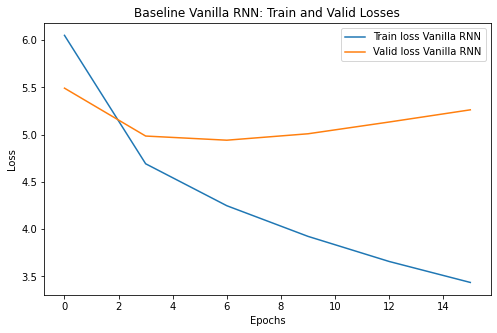

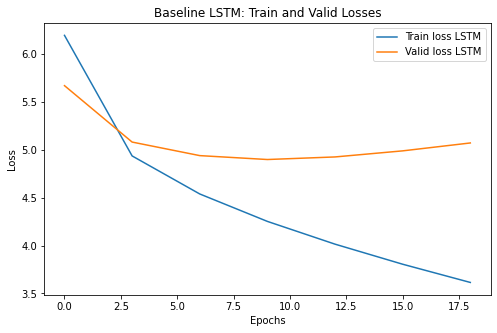

In [39]:
# Vanilla RNN

plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Baseline Vanilla RNN: Train and Valid Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epochs_rnn, loss_train_rnn, label='Train loss Vanilla RNN')
plt.plot(sampled_epochs_rnn, loss_valid_rnn, label='Valid loss Vanilla RNN')
plt.legend()
plt.show()

# LSTM

plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Baseline LSTM: Train and Valid Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epochs_lstm, loss_train_lstm, label='Train loss LSTM')
plt.plot(sampled_epochs_lstm, loss_valid_lstm, label='Valid loss LSTM')
plt.legend()
plt.show()


<br/>

## <center>Improved LSTM Models</center>


<br/>

### Definition of the improved LSTM model

In order to improve the performance and results of the baseline models, I decided to introduce some **regularization** techniques, as well as improve the optimization algorithm, to the training phase of the **LSTM** model.

In particular, the additions I made to the **definition of the architecture** are the following:

* **Embedding dropout** regularization technique to the embedding layer. In general, dropout avoids overfitting by adding some noise in the training phase (the value of **0.1** was suggested by the *Regularizing and Optimizing LSTM Language Models* paper).

* **Locked dropout** regularization technique to the inputs and outputs of the LSTM layer: it samples a
binary dropout mask only once upon the first call and then
it repeatedly uses that locked dropout mask for all repeated
connections within the forward and backward pass. The values of **0.4** were suggested by the *Regularizing and Optimizing LSTM Language Models* paper.

* **Weight tying** of the weights in **embedding** matrix and **decoder** output matrix: this technique allows to substantially reduce the number of parameters of the model, reducing the problem of overfitting and improving the performance in the training procedure.

* **Attention module**: although attention modules are mostly used in the framework of machine translation, because of their ability of providing a good measure for the alignment between the words in the input sentence and translated sentence, I tried implementing a sort of attention layer that could suit and be useful for the considered Language Modeling task. I took inspiration, to some extent, from the general ideas underlying the structure of the **self-attention** module in the Transformer proposed in the *Attention Is All You Need* paper.

* **Residual connections**: as shown with their introduction in ResNet, skip connections implemented through residual blocks improve the results obtained from the training procedure because they help the model in better exploiting its parameters in order to approximate certain complex functions, and they allow to skip some layers when they are not needed. Also, these residual connections encourage **feature reuse**. 
In particular, the whole aforementioned **attention module** is introduced in the architecture as a residual block, hence it can be ignored by the network if it's considered not useful.
<center>
<img src='https://drive.google.com/uc?export=view&id=13QJYClkMM3wd824BtBmNR9UBTw_HNKjZ' width='500'>
</center>

In [12]:
from torch.autograd import Variable

class LockedDropout(nn.Module):
# source: https://github.com/salesforce/awd-lstm-lm/blob/master/locked_dropout.py

    def __init__(self):
        super().__init__()

    def forward(self, x, dropout=0.5):
        if not self.training or not dropout:
            return x
        m = x.data.new(1, x.size(1), x.size(2)).bernoulli_(1 - dropout)
        mask = Variable(m, requires_grad=False) / (1 - dropout)
        mask = mask.expand_as(x)
        return mask * x

class AttentionLayer(nn.Module):

    def __init__(self, hid_size):

        super(AttentionLayer, self).__init__()  

        self.energy = nn.Bilinear(hid_size, hid_size, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=0)
        self.value = nn.Linear(hid_size, hid_size)

    def forward(self, hidden_timesteps):
        # input: (seq_len, batch_size, hid_size)
        n_timesteps = hidden_timesteps.shape[0]
        #batch_size = hidden_timesteps.shape[1]
        #hid_size = hidden_timesteps.shape[2]

        context_vectors = torch.zeros_like(hidden_timesteps)
        context_vectors[0] = hidden_timesteps[0]

        for t in range(1, n_timesteps):
            # For each timestep's hidden state:

            s = max(t-6, 0)

            hidden_previous_t = hidden_timesteps[s:t+1]
            # hidden_previous_t: (t-s+1, batch_size, hid_size)

            hidden_t = hidden_timesteps[t].repeat(t-s+1, 1, 1)
            # hidden_t: (t-s+1, batch_size, hid_size)

            alignment_scores = self.energy(hidden_t, hidden_previous_t)
            # alignment_scores: (t-s+1, batch_size, 1)

            attention = self.softmax(alignment_scores)
            # attention: (t-s+1, batch_size, 1)

            # Residual block with value computation
            values = self.relu(self.value(hidden_previous_t))
            hidden_previous_t = hidden_previous_t + values

            # attention: (t-s+1, batch_size, 1) ----------------------> tnk
            # hidden_previous_t: (t-s+1, batch_size, hid_size) -------> tnh
            # we want context_vectors[t]: (1, batch_size, hid_size) --> knh
            context_vectors[t] = torch.einsum("tnk,tnh->knh", attention, hidden_previous_t)

        return context_vectors


class Improved_LSTM(nn.Module):

    def __init__(self, hid_size, emb_size, vocab_len, attention = True, n_layer = 1, pad_index = 0, tie_weights=True):

        super(Improved_LSTM, self).__init__()  

        self.hid_size = hid_size
        self.emb_size = emb_size
        self.vocab_len = vocab_len
        self.n_layer = n_layer
        self.pad_index = pad_index

        # Dropout regularization 
        # avoids overfitting adding some noise in training phase
        self.lockdrop = LockedDropout()
        self.dropout_emb = nn.Dropout(0.1) 
        self.drop_inp = 0.4
        self.drop_out = 0.4

        # Encoder layer: word embedding layer
        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        
        # We set bidirectionality to false, so the LSTM is one-directional 
        self.lstm = nn.LSTM(emb_size, hid_size, num_layers = n_layer, bidirectional=False)    

        # Attention layer
        self.attention = attention
        if self.attention:
            self.attention_layer = AttentionLayer(hid_size)

        # Decoder layer: linear output layer
        self.decoder = nn.Linear(hid_size, vocab_len)

        # Weight tying regularization technique
        if tie_weights:
            self.decoder.weight = self.embedding.weight
        
    def forward(self, sentences, seq_lengths, hidden = None, cell = None):

        # Dropout applied to the first layer
        # sentences: (batch_size, seq_len)
        sents_emb = self.dropout_emb(self.embedding(sentences)) 
        # sents_emb: (batch_size, seq_len, emb_size)

        # Swap the matrix in order to have dimensions setted in another way
        # We need seq len first -> permute 
        sents_emb = sents_emb.permute(1,0,2) 
        # sents_emb: (seq_len, batch_size, emb_size)
        sents_emb = self.lockdrop(sents_emb, self.drop_inp)

        # Compression
        # pack_padded_sequence avoids computation over pad tokens reducing the computational cost
        packed_input = pack_padded_sequence(sents_emb, seq_lengths.cpu().numpy())

        # Process the batch through the LSTM layer
        if hidden == None:
          packed_output, (last_hidden, last_cell) = self.lstm(packed_input) 
        else:
          hidden = hidden.detach()
          cell = cell.detach()
          packed_output, (last_hidden, last_cell) = self.lstm(packed_input, (hidden, cell)) 


        # Unpack the sequence: Decompression
        padded_output, _ = pad_packed_sequence(packed_output)

        lstm_hs = padded_output
        padded_output = self.lockdrop(padded_output, self.drop_out)
        dropped_lstm_hs = padded_output

        # Residual block with attention layer 
        if self.attention:
            identity = padded_output
            attention_output = self.attention_layer(padded_output)
            attention_output = attention_output + identity
        else:
            attention_output = padded_output
          
        # Get the output
        out = self.decoder(attention_output)

        # Swap the output in order to have dimensions setted correctly for the loss
        out = out.permute(1,0,2).contiguous()
        out = out.view(-1, out.shape[-1])
        # out: (batch_size * seq_len, vocab_len)

        return out, last_hidden, last_cell, lstm_hs, dropped_lstm_hs


<br/>

### Training loop

As done for the architectural design, also in the training pipeline some additional **regularization** and **optimization** techniques are introduced to improve the training and achieve a better performing model.

* A very simple but effective adjustment, which is fundamental for reducing the impact of exploding gradients during training, is represented by **gradient clipping**. The problem of exploding gradients is particularly common with recurrent neural networks, such as LSTMs given the accumulation of gradients unrolled over all the input timesteps. With gradient clipping, pre-determined gradient threshold be introduced, and  then gradients norms that exceed this threshold are scaled down, making the training phase more stable.

* As well as introducing the **weight decay** regularization technique to reduce the problem of overfitting, $L_2$ decay is used also on the individual
unit activations and on the difference in outputs
of the LSTM at different time steps. These last two strategies are labeled
as **Activation Regularization** (AR) and **Temporal Activation
Regularization** (TAR) respectively. Their influence is regulated by the **alpha** and **beta** hyperparameters, and their application was suggested by the *Regularizing and Optimizing LSTM Language Models* paper, which also provides their definition.

In this case, differently from the baseline setting, a sort of **Truncated Backpropagation Through Time** is implemented in order to obtain better gradients during training, reduce the problem of vanishing and exploding gradients, speed up training and converge faster. Indeed, the same amount of improvements in the training perplexity happens **at least 10 epochs before** with respect to the case of simple BPTT.

Only one truncation is applied to the batch, and it is performed **after the 25th position** of the sentences. The first sub-batch obtained from the original one, in which the maximum sentence length is 25, is passed as input to the RNN model and backpropagation and weight update are performed. After that, before considering the second part of the truncated batch, the final values of the hidden state and cell state of the LSTM are **detached from the computational graph** (while their value is maintained unaltered), in order to avoid considering the first subset of timesteps for the computation of future gradients. Besides being detached, they are also **resized** in order to maintain just the ones that are necessary for the processing of the second sub-batch (their batch size value will have to correspond to the second mini-batch size).

The second sub-batch, composed by the remaining parts of the initial sentences, and that could have a **lower batch size** with respect to the initial one, is then passed as input to the RNN. The corresponding loss is then acquired and the backpropagation and weight update steps are performed, limiting the computation of errors and gradients to the timesteps of the current sub-batch.

This clearly implies that if the maximum length of the sentences in the batch is less than 25, the truncation is not performed and a simple BackPropagation Through Time is applied to the batch. In this case, indeed, there is no particular need for TBPTT. 
The specific value of **25** was chosen by considering and studying the frequency distribution of the sentences' lengths for all sentences in the training set. Since the most frequent sentence length is around 20, and **most sentences have length values lower than 25**, this choice for the truncation threshold allows to perform just one backpropagation step for most sentences (the ones with length $<$ 25), while splitting and performing two BPTT steps just for the remaining sequences, that are much fewer. This condition grants a more stable and fast training with respect to setting the truncation threshold to a randomly chosen value.

When a new batch, taken from the dataloader, is processed, the LSTM's hidden state and cell state are detached from the computational graph, while their values are **maintained unaltered**. This didn't happen in the baseline case, in which they were re-initialized to 0 with every new batch.

In [23]:
def train_loop(data_loader, optimizer, cost_function, model, alpha = 2, beta = 1, clip = 0.25, hidden = None, cell = None, device = 'cuda:0'):

    # Set the model in training mode
    model.train()

    # Cumulative loss values obtained for each batch
    loss_sum_array = []

    # Total number of words in the batch
    num_words_array = []

    # Iterate over the training set
    for batch_idx, (inputs, targets, lengths) in enumerate(data_loader):

       if lengths[0].item() > 25:

          inputs_1 = inputs[:, :25]
          targets_1 = targets[:, :25]
          lengths_1 = torch.LongTensor([min(25, k) for k in lengths.tolist()])
          lengths_2 = torch.LongTensor([lengths[i] - lengths_1[i] for i in range(len(lengths)) if lengths[i] - lengths_1[i] != 0])
          inputs_2 = inputs[:len(lengths_2), 25:]
          targets_2 = targets[:len(lengths_2), 25:]

          """ First half of minibatch """

          # Load data into GPU
          inputs_1 = inputs_1.to(device)
          targets_1 = targets_1.to(device)
          lengths_1 = lengths_1.to(device)
            
          # Gradients reset
          optimizer.zero_grad()

          # Forward pass
          if hidden != None:
            hidden = hidden.detach()[:, :len(lengths_1)].contiguous()
            cell = cell.detach()[:, :len(lengths_1)].contiguous()
          outputs_1, hidden, cell, rnn_hs, dropped_rnn_hs = model(inputs_1, lengths_1, hidden, cell)

          # Loss computation
          loss_1 = cost_function(outputs_1, targets_1.view(-1))

          # Update of the loss array and number of words array
          loss_sum_array.append(loss_1.item())
          num_words_array.append((torch.sum(lengths_1)).item())

          # Activation Regularization
          loss_1 = loss_1 + (alpha * dropped_rnn_hs.pow(2).mean())

          # Temporal Activation Regularization (slowness)
          loss_1 = loss_1 + (beta * (rnn_hs[1:] - rnn_hs[:-1]).pow(2).mean())

          # Backward pass
          loss_1.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), clip) 
          
          # Parameters update
          optimizer.step()

          """ Second half of minibatch """

          # Load data into GPU
          inputs_2 = inputs_2.to(device)
          targets_2 = targets_2.to(device)
          lengths_2 = lengths_2.to(device)

            
          # Gradients reset
          optimizer.zero_grad()

          # Forward pass: the hidden state and cell are resized in order to 
          # fit the second mini-batch size
          hidden = hidden.detach()
          cell = cell.detach()
          hidden_2 = hidden[:, :len(lengths_2)].contiguous() 
          cell_2 = cell[:, :len(lengths_2)].contiguous()
          outputs_2, hidden_2, cell_2, rnn_hs, dropped_rnn_hs = model(inputs_2, lengths_2, hidden_2, cell_2)

          # Loss computation
          loss_2 = cost_function(outputs_2, targets_2.view(-1))

          # Update of the loss array and number of words array
          loss_sum_array.append(loss_2.item())
          num_words_array.append((torch.sum(lengths_2)).item())

          # Activation Regularization
          loss_2 = loss_2 + (alpha * dropped_rnn_hs.pow(2).mean())

          # Temporal Activation Regularization (slowness)
          loss_2 = loss_2 + (beta * (rnn_hs[1:] - rnn_hs[:-1]).pow(2).mean())

          # Backward pass
          loss_2.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), clip) 
          
          # Parameters update
          optimizer.step()

          hidden[:, :len(lengths_2)] = hidden_2
          cell[:, :len(lengths_2)] = cell_2

       else:

          """ Entire mini-batch is processed """

          # Load data into GPU
          inputs = inputs.to(device)
          targets = targets.to(device)
          lengths = lengths.to(device)

          # Gradients reset
          optimizer.zero_grad()

          # Forward pass
          if hidden != None:
            hidden = hidden.detach()[:, :len(lengths)].contiguous()
            cell = cell.detach()[:, :len(lengths)].contiguous()
          outputs, hidden, cell, rnn_hs, dropped_rnn_hs = model(inputs, lengths, hidden, cell)

          # Loss computation
          loss = cost_function(outputs, targets.view(-1))

          # Update of the loss array and number of words array
          loss_sum_array.append(loss.item())
          num_words_array.append((torch.sum(lengths)).item())

          # Activation Regularization
          loss = loss + (alpha * dropped_rnn_hs.pow(2).mean())

          # Temporal Activation Regularization (slowness)
          loss = loss + (beta * (rnn_hs[1:] - rnn_hs[:-1]).pow(2).mean())

          # Backward pass
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), clip) 
          
          # Parameters update
          optimizer.step()
      
    return loss_sum_array, num_words_array


<br/>

### Evaluation loop

The evaluation loop remains the same as the one adopted in the case of the baseline models. Indeed, the truncation of the batches into two sub-batches is useful only to improve the learning procedure when applying Backpropagation Through Time.

The only difference from the baseline case is that the values of the hidden states and cell states of the LSTM layer are not re-initialized to 0 each time a new batch is processed; indeed, they are detached from the computational graph but their value is maintained unaltered. 

In [14]:
def eval_loop(data_loader, cost_function, model, hidden = None, cell = None, device = 'cuda:0'):

  # Set the network to evaluation mode
  model.eval() 

  # Cumulative loss values obtained for each batch
  loss_sum_array = []

  # Total number of words in the batch
  num_words_array = []

  # Disable gradient computation 
  with torch.no_grad():

    # Iterate over the test set
    for batch_idx, (inputs, targets, lengths) in enumerate(data_loader):
      
        # Load data into GPU
        inputs = inputs.to(device)
        targets = targets.to(device)
        lengths = lengths.to(device)

        # Forward pass
        if hidden != None:
            hidden = hidden[:, :len(lengths)].contiguous()
            cell = cell[:, :len(lengths)].contiguous()
        outputs, hidden, cell, _, _ = model(inputs, lengths, hidden, cell)

        # Loss computation
        loss = cost_function(outputs, targets.view(-1))

        # Update of the loss array
        loss_sum_array.append(loss.item())
        num_words_array.append((torch.sum(lengths)).item())
      
  return loss_sum_array, num_words_array


<br/>

### Definition of the training procedure


In [24]:
def main(model, 
         prediction_loss,
         optimizer, 
         train_loader, 
         valid_loader, 
         test_loader,
         n_epochs = 200,   
         patience = 3):

    # Vectors filled during training that allow to plot the loss variations across epochs
    losses_train = []
    losses_valid = []
    sampled_epochs = []

    # Initial best loss value, used for the early stopping technique
    best_loss = 100.00


    for x in tqdm(range(1, n_epochs)):

        # For each epoch:
        print('Epoch n. ', x, '\n')

        """ Cross entropy loss and perplexity on the training set """
        loss_train, num_words = train_loop(train_loader, optimizer, prediction_loss, model)

        # Cross entropy
        ce_train = np.asarray(loss_train).sum() / np.asarray(num_words).sum()
        print('CE on the training set: ', ce_train, '\n')

        # Perplexity
        perplexity_train = np.exp(ce_train)
        print('Perplexity on the training set: ', perplexity_train, '\n')

        if x % 3 == 0:

            sampled_epochs.append(x)
            losses_train.append(ce_train)

            """ Cross entropy loss and perplexity on the validation set """
            loss_valid, num_words = eval_loop(valid_loader, prediction_loss, model)

            # Cross entropy
            ce_valid = np.asarray(loss_valid).sum() / np.asarray(num_words).sum()
            print('CE on the validation set: ', ce_valid, '\n')

            # Perplexity
            perplexity_valid = np.exp(ce_valid)
            print('Perplexity on the validation set: ', perplexity_valid, '\n')

            losses_valid.append(ce_valid)

            if ce_valid < best_loss:
                best_loss = ce_valid
            else:
                patience -= 1
            if patience <= 0: 
                # Early stopping with patience
                break 


    """ Cross entropy loss and perplexity on the test set """
    loss_test, num_words = eval_loop(test_loader, prediction_loss, model)

    # Cross entropy
    ce_test = np.asarray(loss_test).sum() / np.asarray(num_words).sum()
    print('CE on the test set: ', ce_test, '\n')

    # Perplexity
    perplexity_test = np.exp(ce_test)
    print('Perplexity on the test set: ', perplexity_test, '\n')


    return losses_train, losses_valid, sampled_epochs, model



<br/>

### Training of the neural network

In order to train the improved LSTM Language Models, the previously defined **main** procedure is invoked, but some important elements and hyperparameters introduced or changed:

*  the **model architecture** corresponds now to the newly defined one: in this case the hidden size and embedding size coincide, otherwise it would not be possible to put in place **weight tying**. Their dimension is set to 500 in order to increase the model's **capacity**.

*  The **optimizer**: I tried training the model both using ASGD, as suggested by the *Regularizing and Optimizing LSTM Language Models* paper, and Adam. For my model, **Adam** optimization resulted in being the best performing one among the two. The learning rate **lr** is initialized to the value that has shown to work well in practice, and **weight decay** regularization is introduced along with the optimization procedure.

*   The **clip** hyperparameter defined the threshold above which to perform gradient norm clipping. Its value was set to 0.25, as proposed in the *Regularizing and Optimizing LSTM Language Models* paper.

In order to show the improvements in the performance brought by the introduction of the **attention module**, the improved LSTM model is trained and evaluated in two cases: with and without the presence of the attention layer. Its introduction in the architecture can be regulated through a simple binary input parameter in the definition of the model. 

<br/>

1.  **Improved model WITHOUT attention**

In [ ]:
# Hyperparameters 
n_epochs = 200        # Number of epochs
patience = 3          # Patience parameter for the early stopping regularization
hid_size = 500        # Size of the hidden LSTM representation 
emb_size = 500        # Size of the embedding vector
lr = 0.001            # Learning rate for the optimization phase
clip = 0.25           # Threshold used to clip the gradient and avoid the exploding gradient problem
wd = 1.2e-5           # Weight decay regularization

# Computation of the length of the vocabulary 
vocab_len = len(vocab.word2id)

# Definition of the model, initialization of the weights
model_noatt = Improved_LSTM(hid_size, emb_size, vocab_len, attention = False, pad_index=PAD_TOKEN, tie_weights=True).to(device)
model_noatt.apply(init_weights)

# Definition of the optimizer
optimizer = torch.optim.Adam(model_noatt.parameters(), lr = lr, weight_decay = wd)
#optimizer = torch.optim.ASGD(model_noatt.parameters(), lr = lr, weight_decay=wd)

# Definition of the loss
prediction_loss = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN, reduction = 'sum')

# Training procedure
loss_train_noatt, loss_valid_noatt, sampled_epochs_noatt, model_noatt = main(model_noatt, 
                                                                        prediction_loss,
                                                                        optimizer, 
                                                                        train_loader, 
                                                                        valid_loader, 
                                                                        test_loader,
                                                                        n_epochs = n_epochs,   
                                                                        patience = patience)
# Save the trained model 
torch.save(model_noatt.state_dict(), "gdrive/MyDrive/NLU_project/models/final_model_noatt")

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch n.  1 



  1%|          | 1/199 [00:29<1:38:48, 29.94s/it]

CE on the training set:  5.920194669568814 

Perplexity on the training set:  372.48421816090377 

Epoch n.  2 



  1%|          | 2/199 [00:59<1:37:20, 29.65s/it]

CE on the training set:  5.353861609159008 

Perplexity on the training set:  211.42315712005765 

Epoch n.  3 

CE on the training set:  5.153573609694759 

Perplexity on the training set:  173.04879550929178 



  2%|▏         | 3/199 [01:29<1:37:32, 29.86s/it]

CE on the validation set:  5.0517420624988905 

Perplexity on the validation set:  156.29450225536107 

Epoch n.  4 



  2%|▏         | 4/199 [01:59<1:37:18, 29.94s/it]

CE on the training set:  5.033255323085079 

Perplexity on the training set:  153.431670267705 

Epoch n.  5 



  3%|▎         | 5/199 [02:28<1:36:10, 29.75s/it]

CE on the training set:  4.951359014487651 

Perplexity on the training set:  141.36695317127666 

Epoch n.  6 

CE on the training set:  4.886910134597233 

Perplexity on the training set:  132.54339942118406 



  3%|▎         | 6/199 [02:59<1:36:06, 29.88s/it]

CE on the validation set:  4.875260362328412 

Perplexity on the validation set:  131.00825838596907 

Epoch n.  7 



  4%|▎         | 7/199 [03:28<1:35:11, 29.75s/it]

CE on the training set:  4.83968817550634 

Perplexity on the training set:  126.429921636502 

Epoch n.  8 



  4%|▍         | 8/199 [03:58<1:34:44, 29.76s/it]

CE on the training set:  4.803760388681202 

Perplexity on the training set:  121.96820410572555 

Epoch n.  9 

CE on the training set:  4.773603875664071 

Perplexity on the training set:  118.34497493066131 



  5%|▍         | 9/199 [04:28<1:34:49, 29.95s/it]

CE on the validation set:  4.812674349494779 

Perplexity on the validation set:  123.06028404525827 

Epoch n.  10 



  5%|▌         | 10/199 [04:58<1:33:48, 29.78s/it]

CE on the training set:  4.749945898325019 

Perplexity on the training set:  115.57803139294731 

Epoch n.  11 



  6%|▌         | 11/199 [05:27<1:33:00, 29.68s/it]

CE on the training set:  4.728729398929088 

Perplexity on the training set:  113.15170030080073 

Epoch n.  12 

CE on the training set:  4.710891543265299 

Perplexity on the training set:  111.15121185894995 



  6%|▌         | 12/199 [05:57<1:32:55, 29.82s/it]

CE on the validation set:  4.7682983450463485 

Perplexity on the validation set:  117.71875472688279 

Epoch n.  13 



  7%|▋         | 13/199 [06:27<1:32:32, 29.85s/it]

CE on the training set:  4.6969705947409555 

Perplexity on the training set:  109.61460190949687 

Epoch n.  14 



  7%|▋         | 14/199 [06:57<1:31:42, 29.74s/it]

CE on the training set:  4.683995227987173 

Perplexity on the training set:  108.20149983278743 

Epoch n.  15 

CE on the training set:  4.672786844328868 

Perplexity on the training set:  106.99550715009322 



  8%|▊         | 15/199 [07:27<1:31:44, 29.92s/it]

CE on the validation set:  4.75330877660401 

Perplexity on the validation set:  115.96736051055511 

Epoch n.  16 



  8%|▊         | 16/199 [07:56<1:30:52, 29.80s/it]

CE on the training set:  4.6629535632785135 

Perplexity on the training set:  105.94854622385154 

Epoch n.  17 



  9%|▊         | 17/199 [08:26<1:30:09, 29.72s/it]

CE on the training set:  4.6547024184341375 

Perplexity on the training set:  105.07794608612653 

Epoch n.  18 

CE on the training set:  4.646008368794296 

Perplexity on the training set:  104.1683529601021 



  9%|▉         | 18/199 [08:57<1:30:27, 29.99s/it]

CE on the validation set:  4.733966571706519 

Perplexity on the validation set:  113.7458497790467 

Epoch n.  19 



 10%|▉         | 19/199 [09:26<1:29:29, 29.83s/it]

CE on the training set:  4.6367031820536955 

Perplexity on the training set:  103.20354281425355 

Epoch n.  20 



 10%|█         | 20/199 [09:56<1:28:42, 29.73s/it]

CE on the training set:  4.632749057708531 

Perplexity on the training set:  102.79626890958247 

Epoch n.  21 

CE on the training set:  4.629239270357868 

Perplexity on the training set:  102.4361082786047 



 11%|█         | 21/199 [10:26<1:28:32, 29.84s/it]

CE on the validation set:  4.727654376370712 

Perplexity on the validation set:  113.03012503024632 

Epoch n.  22 



 11%|█         | 22/199 [10:56<1:28:07, 29.88s/it]

CE on the training set:  4.622868866757416 

Perplexity on the training set:  101.78562305215809 

Epoch n.  23 



 12%|█▏        | 23/199 [11:25<1:27:14, 29.74s/it]

CE on the training set:  4.615642140731768 

Perplexity on the training set:  101.0526977559507 

Epoch n.  24 

CE on the training set:  4.612286308289339 

Perplexity on the training set:  100.71415020656694 



 12%|█▏        | 24/199 [11:55<1:27:02, 29.84s/it]

CE on the validation set:  4.719058517583952 

Perplexity on the validation set:  112.06269792704671 

Epoch n.  25 



 13%|█▎        | 25/199 [12:25<1:26:19, 29.77s/it]

CE on the training set:  4.607303047975978 

Perplexity on the training set:  100.21351381559792 

Epoch n.  26 



 13%|█▎        | 26/199 [12:54<1:25:33, 29.67s/it]

CE on the training set:  4.604435233315628 

Perplexity on the training set:  99.92653173390991 

Epoch n.  27 

CE on the training set:  4.60033446168875 

Perplexity on the training set:  99.51759489915557 



 14%|█▎        | 27/199 [13:25<1:25:53, 29.96s/it]

CE on the validation set:  4.702830480875524 

Perplexity on the validation set:  110.25881666449409 

Epoch n.  28 



 14%|█▍        | 28/199 [13:54<1:24:58, 29.82s/it]

CE on the training set:  4.597208533835347 

Perplexity on the training set:  99.20699578548326 

Epoch n.  29 



 15%|█▍        | 29/199 [14:24<1:24:09, 29.70s/it]

CE on the training set:  4.59526373228634 

Perplexity on the training set:  99.01424535782506 

Epoch n.  30 

CE on the training set:  4.592030641252163 

Perplexity on the training set:  98.69464022354929 



 15%|█▌        | 30/199 [14:54<1:23:59, 29.82s/it]

CE on the validation set:  4.704808384119948 

Perplexity on the validation set:  110.47711374979112 

Epoch n.  31 



 16%|█▌        | 31/199 [15:24<1:23:47, 29.93s/it]

CE on the training set:  4.589619847689723 

Perplexity on the training set:  98.45699439286871 

Epoch n.  32 



 16%|█▌        | 32/199 [15:54<1:23:01, 29.83s/it]

CE on the training set:  4.586842669733693 

Perplexity on the training set:  98.18394113266997 

Epoch n.  33 

CE on the training set:  4.584919976348843 

Perplexity on the training set:  97.99534488303586 



 17%|█▋        | 33/199 [16:24<1:22:49, 29.94s/it]

CE on the validation set:  4.705938041763967 

Perplexity on the validation set:  110.60198558375926 

Epoch n.  34 



 17%|█▋        | 34/199 [16:53<1:21:57, 29.80s/it]

CE on the training set:  4.583081324245039 

Perplexity on the training set:  97.81533107809776 

Epoch n.  35 



 18%|█▊        | 35/199 [17:23<1:21:13, 29.72s/it]

CE on the training set:  4.580225754305546 

Perplexity on the training set:  97.53641098649679 

Epoch n.  36 

CE on the training set:  4.576608272093108 

Perplexity on the training set:  97.18421217523358 



 18%|█▊        | 35/199 [17:54<1:23:53, 30.69s/it]

CE on the validation set:  4.7036897941380165 

Perplexity on the validation set:  110.35360424824181 



CE on the test set:  4.672596721384655 

Perplexity on the test set:  106.9751667829028 




<br/>

In order to **assess the reliability** of the obtained result for the test loss and perplexity, at this point multiple runs (**5**) of training and test of the aforementioned model are executed, maintaining exactly the same setting described above for each run.  

At the end of each run the test loss and perplexity values are stored, and in the end the results' **mean** and **standard deviation** is computed and printed. 

In [38]:
# Definition of the number of runs
runs = 5 

test_loss_runs, test_perplexity_runs = [], []

for x in tqdm(range(0, runs)):

    # Hyperparameters 
    n_epochs = 200        # Number of epochs
    patience = 3          # Patience parameter for the early stopping regularization
    hid_size = 500        # Size of the hidden LSTM representation 
    emb_size = 500        # Size of the embedding vector
    lr = 0.001            # Learning rate for the optimization phase
    clip = 0.25           # Threshold used to clip the gradient and avoid the exploding gradient problem
    wd = 1.2e-5           # Weight decay regularization

    # Computation of the length of the vocabulary 
    vocab_len = len(vocab.word2id)

    # Definition of the model, initialization of the weights
    model_noatt = Improved_LSTM(hid_size, emb_size, vocab_len, attention = False, pad_index=PAD_TOKEN, tie_weights=True).to(device)
    model_noatt.apply(init_weights)

    # Definition of the optimizer
    optimizer = torch.optim.Adam(model_noatt.parameters(), lr = lr, weight_decay = wd)

    # Definition of the loss
    prediction_loss = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN, reduction = 'sum')
    

    # Initial best loss value, used for the early stopping technique
    best_loss = 100.00


    for x in range(1, n_epochs):

        # For each epoch:
        """ Training step """
        loss_train, num_words = train_loop(train_loader, optimizer, prediction_loss, model_noatt)

        if x % 3 == 0:

            """ Validation step """
            loss_valid, num_words = eval_loop(valid_loader, prediction_loss, model_noatt)

            # Cross entropy
            ce_valid = np.asarray(loss_valid).sum() / np.asarray(num_words).sum()

            if ce_valid < best_loss:
                best_loss = ce_valid
            else:
                patience -= 1
            if patience <= 0: 
                # Early stopping with patience
                break 


    """ Cross entropy loss and perplexity on the test set """
    loss_test, num_words = eval_loop(test_loader, prediction_loss, model_noatt)

    # Cross entropy
    ce_test = np.asarray(loss_test).sum() / np.asarray(num_words).sum()
    test_loss_runs.append(ce_test)

    # Perplexity
    perplexity_test = np.exp(ce_test)
    test_perplexity_runs.append(perplexity_test)
    print(perplexity_test)

test_loss_runs = np.asarray(test_loss_runs)
test_perplexity_runs = np.asarray(test_perplexity_runs)

# Computation of mean and standard deviation values among the results of the 5 runs
print('Test loss', round(test_loss_runs.mean(),3), '+-', round(test_loss_runs.std(),3))
print('Test perplexity', round(test_perplexity_runs.mean(), 3), '+-', round(test_perplexity_runs.std(), 3))

 20%|██        | 1/5 [29:46<1:59:05, 1786.38s/it]

106.0367830443064


 40%|████      | 2/5 [1:03:09<1:35:42, 1914.14s/it]

105.69032445965743


 60%|██████    | 3/5 [1:34:47<1:03:33, 1906.54s/it]

105.23669994845878


 80%|████████  | 4/5 [2:06:31<31:45, 1905.55s/it]  

105.74162403878158


100%|██████████| 5/5 [2:34:31<00:00, 1854.33s/it]

105.96736698019647
Test loss 4.661 +- 0.003
Test perplexity 105.735 +- 0.281


<br/>

2.  **Improved model WITH attention**

In [ ]:
# Hyperparameters 
n_epochs = 200        # Number of epochs
patience = 3          # Patience parameter for the early stopping regularization
hid_size = 500        # Size of the hidden LSTM representation 
emb_size = 500        # Size of the embedding vector
lr = 0.001            # Learning rate for the optimization phase
clip = 0.25           # Threshold used to clip the gradient and avoid the exploding gradient problem
wd = 1.2e-5           # Weight decay regularization

# Computation of the length of the vocabulary 
vocab_len = len(vocab.word2id)

# Definition of the model, initialization of the weights
model_att = Improved_LSTM(hid_size, emb_size, vocab_len, attention = True, pad_index=PAD_TOKEN, tie_weights=True).to(device)
model_att.apply(init_weights)

# Definition of the optimizer
optimizer = torch.optim.Adam(model_att.parameters(), lr = lr, weight_decay = wd)
#optimizer = torch.optim.ASGD(model_att.parameters(), lr = lr, weight_decay=wd)

# Definition of the loss
prediction_loss = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN, reduction = 'sum')

# Training procedure
loss_train_att, loss_valid_att, sampled_epochs_att, model_att = main(model_att,
                                                                    prediction_loss, 
                                                                    optimizer, 
                                                                    train_loader, 
                                                                    valid_loader, 
                                                                    test_loader,
                                                                    n_epochs = n_epochs,   
                                                                    patience = patience)
# Save the trained model 
torch.save(model_att.state_dict(), "gdrive/MyDrive/NLU_project/models/final_model_att")

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch n.  1 



  1%|          | 1/199 [02:11<7:12:44, 131.14s/it]

CE on the training set:  5.8135714651943085 

Perplexity on the training set:  334.812765021987 

Epoch n.  2 



  1%|          | 2/199 [04:22<7:10:16, 131.05s/it]

CE on the training set:  5.185196735459563 

Perplexity on the training set:  178.60858497559096 

Epoch n.  3 

CE on the training set:  4.969149752022566 

Perplexity on the training set:  143.9044808465604 



  2%|▏         | 3/199 [06:34<7:09:43, 131.55s/it]

CE on the validation set:  4.897575512601666 

Perplexity on the validation set:  133.96459017459165 

Epoch n.  4 



  2%|▏         | 4/199 [08:45<7:07:36, 131.57s/it]

CE on the training set:  4.838642782185973 

Perplexity on the training set:  126.29782170115413 

Epoch n.  5 



  3%|▎         | 5/199 [10:56<7:04:49, 131.39s/it]

CE on the training set:  4.752013655484818 

Perplexity on the training set:  115.8172659491191 

Epoch n.  6 

CE on the training set:  4.691887587848604 

Perplexity on the training set:  109.05884379025495 



  3%|▎         | 6/199 [13:09<7:04:23, 131.93s/it]

CE on the validation set:  4.74847043591952 

Perplexity on the validation set:  115.40762609694363 

Epoch n.  7 



  4%|▎         | 7/199 [15:20<7:01:14, 131.64s/it]

CE on the training set:  4.645875164269331 

Perplexity on the training set:  104.15447818824138 

Epoch n.  8 



  4%|▍         | 8/199 [17:32<6:58:42, 131.53s/it]

CE on the training set:  4.611623496136624 

Perplexity on the training set:  100.64741776184042 

Epoch n.  9 

CE on the training set:  4.5837941206267665 

Perplexity on the training set:  97.88507834701508 



  5%|▍         | 9/199 [19:44<6:57:18, 131.78s/it]

CE on the validation set:  4.706641634304189 

Perplexity on the validation set:  110.67983169851111 

Epoch n.  10 



  5%|▌         | 10/199 [21:55<6:54:00, 131.43s/it]

CE on the training set:  4.561781558455509 

Perplexity on the training set:  95.75391916550363 

Epoch n.  11 



  6%|▌         | 11/199 [24:06<6:51:12, 131.24s/it]

CE on the training set:  4.541545452516741 

Perplexity on the training set:  93.83570674662835 

Epoch n.  12 

CE on the training set:  4.525375504026779 

Perplexity on the training set:  92.33058982829021 



  6%|▌         | 12/199 [26:18<6:49:59, 131.55s/it]

CE on the validation set:  4.678245575432412 

Perplexity on the validation set:  107.58116386991914 

Epoch n.  13 



  7%|▋         | 13/199 [28:28<6:46:41, 131.19s/it]

CE on the training set:  4.514084126451716 

Perplexity on the training set:  91.29391403992824 

Epoch n.  14 



  7%|▋         | 14/199 [30:39<6:43:45, 130.95s/it]

CE on the training set:  4.503381164768302 

Perplexity on the training set:  90.3220091841442 

Epoch n.  15 

CE on the training set:  4.49399627537106 

Perplexity on the training set:  89.47831231118829 



  8%|▊         | 15/199 [32:50<6:41:45, 131.01s/it]

CE on the validation set:  4.6624324806713044 

Perplexity on the validation set:  105.893352660607 

Epoch n.  16 



  8%|▊         | 16/199 [34:59<6:38:10, 130.55s/it]

CE on the training set:  4.484543235558992 

Perplexity on the training set:  88.63645558418658 

Epoch n.  17 



  9%|▊         | 17/199 [37:09<6:35:39, 130.44s/it]

CE on the training set:  4.474880082980931 

Perplexity on the training set:  87.78407297420529 

Epoch n.  18 

CE on the training set:  4.467718803301583 

Perplexity on the training set:  87.15767226858853 



  9%|▉         | 18/199 [39:21<6:34:32, 130.79s/it]

CE on the validation set:  4.6619017947717625 

Perplexity on the validation set:  105.83717146009877 

Epoch n.  19 



 10%|▉         | 19/199 [41:31<6:31:51, 130.62s/it]

CE on the training set:  4.463512400250985 

Perplexity on the training set:  86.79182196642927 

Epoch n.  20 



 10%|█         | 20/199 [43:41<6:29:04, 130.42s/it]

CE on the training set:  4.455925521167438 

Perplexity on the training set:  86.13583450310182 

Epoch n.  21 

CE on the training set:  4.452342669405865 

Perplexity on the training set:  85.82777477243455 



 11%|█         | 21/199 [45:53<6:28:30, 130.96s/it]

CE on the validation set:  4.651059481521479 

Perplexity on the validation set:  104.69585015587309 

Epoch n.  22 



 11%|█         | 22/199 [48:04<6:25:58, 130.84s/it]

CE on the training set:  4.446031599917721 

Perplexity on the training set:  85.28781537466898 

Epoch n.  23 



 12%|█▏        | 23/199 [50:14<6:23:20, 130.68s/it]

CE on the training set:  4.442244938857377 

Perplexity on the training set:  84.96547001674575 

Epoch n.  24 

CE on the training set:  4.436686617232596 

Perplexity on the training set:  84.49451468051753 



 12%|█▏        | 24/199 [52:27<6:22:55, 131.29s/it]

CE on the validation set:  4.643160285413189 

Perplexity on the validation set:  103.8720948893032 

Epoch n.  25 



 13%|█▎        | 25/199 [54:38<6:20:24, 131.18s/it]

CE on the training set:  4.435627755345097 

Perplexity on the training set:  84.40509400964459 

Epoch n.  26 



 13%|█▎        | 26/199 [56:49<6:17:49, 131.04s/it]

CE on the training set:  4.431742128636406 

Perplexity on the training set:  84.07776367559404 

Epoch n.  27 

CE on the training set:  4.427624984853805 

Perplexity on the training set:  83.73231505241881 



 14%|█▎        | 27/199 [59:01<6:17:07, 131.55s/it]

CE on the validation set:  4.651076043128019 

Perplexity on the validation set:  104.6975841017082 

Epoch n.  28 



 14%|█▍        | 28/199 [1:01:12<6:14:30, 131.41s/it]

CE on the training set:  4.425812810945135 

Perplexity on the training set:  83.5807149401398 

Epoch n.  29 



 15%|█▍        | 29/199 [1:03:23<6:11:40, 131.18s/it]

CE on the training set:  4.421151033804241 

Perplexity on the training set:  83.19198705917839 

Epoch n.  30 

CE on the training set:  4.418520194041453 

Perplexity on the training set:  82.97340991846441 



 15%|█▌        | 30/199 [1:05:36<6:10:49, 131.65s/it]

CE on the validation set:  4.649643254324123 

Perplexity on the validation set:  104.5476819900902 

Epoch n.  31 



 16%|█▌        | 31/199 [1:07:47<6:08:02, 131.44s/it]

CE on the training set:  4.416674550732242 

Perplexity on the training set:  82.82041183298337 

Epoch n.  32 



 16%|█▌        | 32/199 [1:09:58<6:05:38, 131.37s/it]

CE on the training set:  4.413904425049715 

Perplexity on the training set:  82.59130635511674 

Epoch n.  33 

CE on the training set:  4.411203398572559 

Perplexity on the training set:  82.36852605305786 



 17%|█▋        | 33/199 [1:12:11<6:04:55, 131.90s/it]

CE on the validation set:  4.635888859168561 

Perplexity on the validation set:  103.11953601648412 

Epoch n.  34 



 17%|█▋        | 34/199 [1:14:22<6:01:58, 131.63s/it]

CE on the training set:  4.410248169993992 

Perplexity on the training set:  82.28988285009494 

Epoch n.  35 



 18%|█▊        | 35/199 [1:16:34<5:59:54, 131.68s/it]

CE on the training set:  4.406826312339189 

Perplexity on the training set:  82.00877980614165 

Epoch n.  36 

CE on the training set:  4.406659845709098 

Perplexity on the training set:  81.99512921714474 



 18%|█▊        | 35/199 [1:18:47<6:09:11, 135.07s/it]

CE on the validation set:  4.639139123876793 

Perplexity on the validation set:  103.45524708450233 



CE on the test set:  4.604309276769002 

Perplexity on the test set:  99.91394612569295 




<br/>

In order to **assess the reliability** of the obtained result for the test loss and perplexity, at this point multiple runs (**5**) of training and test of the aforementioned model are executed, maintaining exactly the same setting described above for each run.  

At the end of each run the test loss and perplexity values are stored, and in the end the results' **mean** and **standard deviation** is computed and printed. 

In [15]:
# Definition of the number of runs
runs = 5 

test_loss_runs, test_perplexity_runs = [], []

for x in tqdm(range(0, runs)):

    # Hyperparameters 
    n_epochs = 200        # Number of epochs
    patience = 3          # Patience parameter for the early stopping regularization
    hid_size = 500        # Size of the hidden LSTM representation 
    emb_size = 500        # Size of the embedding vector
    lr = 0.001            # Learning rate for the optimization phase
    clip = 0.25           # Threshold used to clip the gradient and avoid the exploding gradient problem
    wd = 1.2e-5           # Weight decay regularization

    # Computation of the length of the vocabulary 
    vocab_len = len(vocab.word2id)

    # Definition of the model, initialization of the weights
    model_att = Improved_LSTM(hid_size, emb_size, vocab_len, attention = True, pad_index=PAD_TOKEN, tie_weights=True).to(device)
    model_att.apply(init_weights)

    # Definition of the optimizer
    optimizer = torch.optim.Adam(model_att.parameters(), lr = lr, weight_decay = wd)

    # Definition of the loss
    prediction_loss = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN, reduction = 'sum')
    

    # Initial best loss value, used for the early stopping technique
    best_loss = 100.00


    for x in range(1, n_epochs):

        # For each epoch:
        """ Training step """
        loss_train, num_words = train_loop(train_loader, optimizer, prediction_loss, model_att)

        if x % 3 == 0:

            """ Validation step """
            loss_valid, num_words = eval_loop(valid_loader, prediction_loss, model_att)

            # Cross entropy
            ce_valid = np.asarray(loss_valid).sum() / np.asarray(num_words).sum()

            if ce_valid < best_loss:
                best_loss = ce_valid
            else:
                patience -= 1
            if patience <= 0: 
                # Early stopping with patience
                break 


    """ Cross entropy loss and perplexity on the test set """
    loss_test, num_words = eval_loop(test_loader, prediction_loss, model_att)

    # Cross entropy
    ce_test = np.asarray(loss_test).sum() / np.asarray(num_words).sum()
    test_loss_runs.append(ce_test)

    # Perplexity
    perplexity_test = np.exp(ce_test)
    test_perplexity_runs.append(perplexity_test)
    print(perplexity_test)


test_loss_runs = np.asarray(test_loss_runs)
test_perplexity_runs = np.asarray(test_perplexity_runs)

# Computation of mean and standard deviation values among the results of the 5 runs
print('Test loss', round(test_loss_runs.mean(),3), '+-', round(test_loss_runs.std(),3))
print('Test perplexity', round(test_perplexity_runs.mean(), 3), '+-', round(test_perplexity_runs.std(), 3))

 20%|██        | 1/5 [1:13:28<4:53:53, 4408.46s/it]

100.88950504731793


 40%|████      | 2/5 [2:46:57<4:15:44, 5114.84s/it]

100.15998993067198


 60%|██████    | 3/5 [4:20:27<2:58:01, 5340.79s/it]

100.31901766844857


 80%|████████  | 4/5 [5:53:01<1:30:24, 5424.89s/it]

99.42241199578274


100%|██████████| 5/5 [6:58:51<00:00, 5026.37s/it]

100.86198328298684
Test loss 4.608 +- 0.005
Test perplexity 100.331 +- 0.538



<br/>

### Plot of the training and validation losses for the improved models

The plots clearly show that the improved LSTM architecture performs generally better with respect to the starting baseline models, 
  -  the final **perplexity values** for the validation and test set are much **lower**,
  -  the **training procedure is smoother**, less affected by the problems of vanishing and exploding gradient,
  -  the gap between training error and validation/test errors is smaller: the model is **less prone to overfit** and it is characterized by **higher generalization capabilities**.


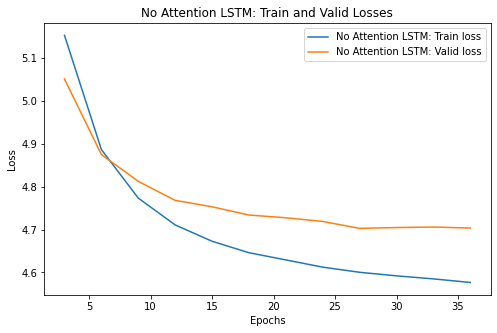

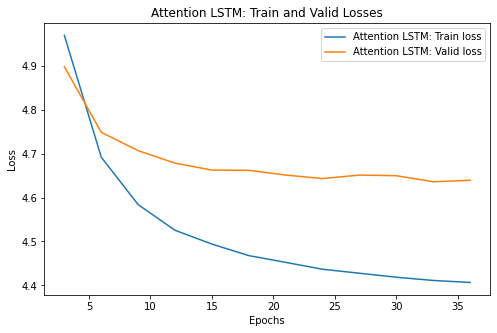

In [ ]:
# Improved LSTM without Attention

plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('No Attention LSTM: Train and Valid Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epochs_noatt, loss_train_noatt, label='No Attention LSTM: Train loss')
plt.plot(sampled_epochs_noatt, loss_valid_noatt, label='No Attention LSTM: Valid loss')
plt.legend()
plt.show()

# Improved LSTM with Attention

plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Attention LSTM: Train and Valid Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epochs_att, loss_train_att, label='Attention LSTM: Train loss')
plt.plot(sampled_epochs_att, loss_valid_att, label='Attention LSTM: Valid loss')
plt.legend()
plt.show()


<br/>

## <center>Models comparison and error analysis</center>

As clearly shown by the obtained results, the **improved LSTM model with attention** is the one that grants the most stable training procedure, with the best resulting model.

Although the improvement in Perplexity score with respect to the baseline models is remarkable, the final perplexity value obtained by the improved model on the test set is still quite high, that is around the value of 100. In order to understand the behaviour of the network when it deals with previously unseen sentences, a detailed **error analysis** must be carried out. 

For the sake of studying the behaviour of the network, a run on all the samples of the test set is performed and the obtained predictions are stored and analyzed. 

In [31]:
# Output predictions
test_outputs_idx = []
test_inputs_idx = []
test_targets_idx = []
test_outputs = []
test_inputs = []
test_targets = []
test_loss = []
lengths = []

# Definition of the model
hid_size = 500        
emb_size = 500 
vocab_len = len(vocab.word2id)

model = Improved_LSTM(hid_size, emb_size, vocab_len, attention = True, pad_index=PAD_TOKEN, tie_weights=True).to(device)
model.load_state_dict(torch.load("gdrive/MyDrive/NLU_project/models/final_model_att"))

# Set the network to evaluation mode
model.eval()

# Define a dataloader for the test set with batch_size = 1
test_loader = DataLoader(test_dataset, batch_size = 1, collate_fn=collate_fn)

# Definition of the cost function
# In this case reduction = 'mean' -> the mean is computed already
cost_function = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)

# Disable gradient computation 
with torch.no_grad():

  # Iterate over the test set
  for batch_idx, (inputs, targets, length) in enumerate(test_loader):
    
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)
      length = length.to(device)
        
      # Forward pass
      outputs, _, _, _, _ = model(inputs, length)
      _, predicted_index = outputs.max(dim = 1)

      # Loss computation
      loss = cost_function(outputs, targets.view(-1))

      # Update of the outputs array
      test_outputs_idx.append(predicted_index)
      test_inputs_idx.append(inputs)
      test_targets_idx.append(targets)
      test_loss.append(loss.item())
      lengths.append(length.item())

# For each sentence in the predictions
for sent_idx in test_outputs_idx:

      # Convert list of indexes to list of words
      sent_idx = sent_idx.tolist()
      sent = [vocab.id2word[id] for id in sent_idx]
      test_outputs.append(sent)

# For each sentence in the inputs
for sent_idx in test_inputs_idx:

      # Convert list of indexes to list of words
      sent_idx = sent_idx.tolist()
      sent = [vocab.id2word[id] for id in sent_idx[0]]
      test_inputs.append(sent)

# For each sentence in the targets
for sent_idx in test_targets_idx:

      # Convert list of indexes to list of words
      sent_idx = sent_idx.tolist()
      sent = [vocab.id2word[id] for id in sent_idx[0]]
      test_targets.append(sent)

# Test triplets: [(input, target, prediction, sentence-level loss, sentence length)]
test_tuples = [(test_inputs[i], test_targets[i], test_outputs[i], test_loss[i], lengths[i]) for i in range(len(test_loss))]
sorted_tuples = sorted(test_tuples, key=lambda tup: tup[3])


<br/>

In order to evaluate the coherence of the results, it may be a good idea  to compute the number of times the model predicts the **'pad'** token. 

Indeed, **'pad'** is used just for padding and, even though it is contained in the vocabulary and hence could be predicted, it should never be, if the model learns to behave well. As expected, it does not belong to the set of predicted words, and this implies the model behaves well in this sense. 

In [34]:
# List of words in the test set's predictions
predicted_words = []
for sent in test_outputs:
  for w in sent:
    predicted_words.append(w) 

# Set of predicted words
predicted_set = set(predicted_words)
print("'pad' token belongs to the predicted words: ", 'pad' in predicted_set, "\n")

'pad' token belongs to the predicted words:  False 




<br/>

Another starting point to assess the effectiveness of the training could be analyzing whether the most frequently predicted words on the test set are someway aligned to the most frequently appearing words in the training set.

Indeed, it is easily verified by analyzing the Frequency Dictionaries that the most frequent predicted words correspond also to the most frequent ones of **both the training and test sets**. This reflects the ability of the model to learn the statistical properties of words appearances from the training data.

In [36]:
# Frequency list of the words in the training set 

training_freqdist = nltk.FreqDist(train_words_list)
print("First 50 words of the training Frequency Dictionary: ")
sorted_dict_train = dict(sorted(training_freqdist.items(), key=lambda item: item[1], reverse=True)[:50])
print(sorted_dict_train, '\n')

# Frequency list of the words in the test set

test_freqdist = nltk.FreqDist(test_words_list)
print("First 50 words of the test Frequency Dictionary: ")
print(dict(sorted(test_freqdist.items(), key=lambda item: item[1], reverse=True)[:50]), '\n')

# Frequency list of the predicted words on the test set

predicted_freqdist = nltk.FreqDist(predicted_words)
print("First 50 words of the predicted words' Frequency Dictionary: ")
print(dict(sorted(predicted_freqdist.items(), key=lambda item: item[1], reverse=True)[:50]), '\n')

First 50 words of the training Frequency Dictionary: 
{'the': 50770, '<unk>': 45020, 'N': 32481, 'of': 24400, 'to': 23638, 'a': 21196, 'in': 18000, 'and': 17474, "'s": 9784, 'that': 8931, 'for': 8927, '$': 7541, 'is': 7337, 'it': 6112, 'said': 6027, 'on': 5650, 'by': 4915, 'at': 4894, 'as': 4833, 'from': 4724, 'million': 4627, 'with': 4585, 'mr.': 4326, 'was': 4073, 'be': 3923, 'are': 3914, 'its': 3846, 'he': 3632, 'but': 3541, 'has': 3494, 'an': 3477, "n't": 3388, 'will': 3270, 'have': 3245, 'new': 2793, 'or': 2704, 'company': 2680, 'they': 2562, 'this': 2438, 'year': 2379, 'which': 2362, 'would': 2308, 'about': 2220, 'says': 2092, 'more': 2065, 'were': 2009, 'market': 2005, 'billion': 1881, 'his': 1852, 'had': 1850} 

First 50 words of the test Frequency Dictionary: 
{'<unk>': 4794, 'the': 4529, 'N': 2523, 'of': 2195, 'to': 2042, 'a': 1821, 'in': 1640, 'and': 1539, "'s": 903, 'that': 831, 'for': 783, 'is': 667, 'said': 601, '$': 564, 'it': 542, 'on': 507, 'as': 461, 'by': 450, 'at': 


<br/>

It may also be interesting to test whether the model has learnt how to use **the end-of-sequence token "\</s>"** properly, that is, to mark the  end of a meaningful sentence and the start of a new one. 

In order to do this, the 50 most frequent predicted words are considered and some plausible **start-of-sentence** words are chosen among them. 
Starting from these, the network is then used as a generative model, and it is asked to predict the successive word, given the previously predicted one. This generative process stops when the end-of-sequence token **"\</s>"** is reached or more than 100 iterations are executed.

Some of the most plausible start-of-sentence words among the ones belonging to the 50 most frequently predicted are: **"the"**, **"N"**, **"be"**, **"a"**, **"\</s\>"**.

It is quite clear from the sentences generated by the model that when no proper and significant context is provided, it has a tendency for outputting some of the most frequently seen words in the training phase, such as **"\<unk\>"**, **"N"**, **"\</s\>"**. It is particularly interesting to notice that, when provided with the end-of-sentence token **"\</s\>"** as input, the model predicts **"the"**, which is a totally valid choice for the start of a new sentence.

In [ ]:
# For each start-of-sentence token 
for starting_token in ["the", "N", "be", "a", "</s>"]:

    sent = []

    # Map to index format
    input = torch.LongTensor([[vocab.word2id[starting_token]]]).to(device)
    length = torch.LongTensor([1]).to(device)

    # Computation of the output
    output, _, _, _, _ = model(input, length)
    _, predicted_index = output.max(dim = 1)

    # Map to word format
    pred_word = vocab.id2word[predicted_index.item()]

    # Update the generated sentence
    sent.append(pred_word)

    t = 0 

    # While stopping criteria is not met
    while pred_word != "</s>" and t < 100:

        # Map to index format
        input = torch.LongTensor([[vocab.word2id[pred_word]]]).to(device)
        length = torch.LongTensor([1]).to(device)

        # Computation of the output
        output, _, _, _, _ = model(input, length)
        _, predicted_index = output.max(dim = 1)

        # Map to word format
        pred_word = vocab.id2word[predicted_index.item()]

        # Update the generated sentence
        sent.append(pred_word)
        t = t + 1

    print(" ".join(word for word in sent))

<unk> </s>
N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N
<unk> </s>
spokesman </s>
the <unk> </s>



<br/>

In order to better perform the error analysis, it could be useful to print and study the characteristics of the test sentences on which the model scored the worst and the best.

* **Sentences on which the model obtained the lowest perplexity values**:
Very interestingly, of the 30 sentences with lower loss, 18 were already present in the training data. For what concerns the other 12, they are characterized by being very short or, if longer, very repetitive and with no underlying complex structure or meaning. These are the cases in which not too much effort must be put in place to capture and exploit contextual information.

In [ ]:
for i in range(30):
    # Extract the tuple
    (input, target, output, loss, _) = sorted_tuples[i]

    print("Input sentence: ", " ".join(input))
    print("Target sentence: ", " ".join(target))
    print("predicted sentence: ", " ".join(output))
    print("Loss: ", loss)
    print("This sentence also belonged to the training set: ", input in train_sents, "\n")

Input sentence:  revenue rose N N to $ N billion from $ N billion
Target sentence:  rose N N to $ N billion from $ N billion </s>
predicted sentence:  rose N N to $ N billion from $ N billion </s>
Loss:  0.22633951902389526
This sentence also belonged to the training set:  True 

Input sentence:  N N N to N days N N N to N days N N N to N days N N N to N days N N N to N days N N N to N days N N N to N days N N N to N days
Target sentence:  N N to N days N N N to N days N N N to N days N N N to N days N N N to N days N N N to N days N N N to N days N N N to N days </s>
predicted sentence:  N </s> </s> N days N N N to N days N N N to N days N N N to N days N N N to N days N N N to N days N N N to N days N N N to N days N
Loss:  0.29104653000831604
This sentence also belonged to the training set:  False 

Input sentence:  markets
Target sentence:  </s>
predicted sentence:  </s>
Loss:  0.3347003161907196
This sentence also belonged to the training set:  True 

Input sentence:  net fell to 


<br/>

* **Sentences on which the model obtained the highest perplexity values**:
Qualitatively, they often contain words that usually appear quite rarely, and supposedly they almost always consist in small cuts of longer periods that are quite difficult to contextualize and make a sense of. For this reason, with no proper context, the model struggles in predicting correctly and just outputs the guesses with the highest overall probability, such as **"\<unk\>"**, **"\</s\>"** and **"the"**. 

In [ ]:
for i in range(30):
    # Extract the tuple
    (input, target, output, loss, _) = sorted_tuples[-(i + 1)]

    print("Input sentence: ", " ".join(input))
    print("Target sentence: ", " ".join(target))
    print("Predicted sentence: ", " ".join(output))
    print("Loss: ", loss)
    print("This sentence also belonged to the training set: ", input in train_sents, "\n")

Input sentence:  as commonly understood service implies sacrifice
Target sentence:  commonly understood service implies sacrifice </s>
Predicted sentence:  the as the </s> that <unk>
Loss:  9.352524757385254
This sentence also belonged to the training set:  False 

Input sentence:  european drama has had better though still mixed fortunes
Target sentence:  drama has had better though still mixed fortunes </s>
Predicted sentence:  <unk> <unk> been been than the <unk> the </s>
Loss:  7.862180233001709
This sentence also belonged to the training set:  False 

Input sentence:  fcc counsel joins firm
Target sentence:  counsel joins firm </s>
Predicted sentence:  </s> <unk> the of
Loss:  7.854410648345947
This sentence also belonged to the training set:  False 

Input sentence:  replied a justin salesman exactly
Target sentence:  a justin salesman exactly </s>
Predicted sentence:  </s> <unk> <unk> in the
Loss:  7.8230133056640625
This sentence also belonged to the training set:  False 

Inpu


<br/>

In order to understand how the Perplexity is correlated with the length of the test sequences, I performed two types of analysis on the length-loss pairs. First of all I plotted **how the typical sentence length varies with respect to the loss, for increasing loss values**. Additionally, I computed and visualized the **mean and standard deviation of the loss values for each length** value in the test data.

The results are the same in both cases and they show, very interestingly, that while the mean loss value is almost the same for all lengths, the standard deviation tendentially decreases with the increase in length. This happens because longer sequences yield more substantial contextual info, and the performance of the model on them depends on its ability to capture and interpret that info, hence its score is quite stable in this case. For what concerns shorter sentences, instead, as observed during the qualitative analysis, some may be difficult to interpret because of the lack of context, while others can be so repetitive that guessing right is particularly easy; for this reason the model could perform poorly or brilliantly depending on the specific case, and the scores are characterized by high variability. 

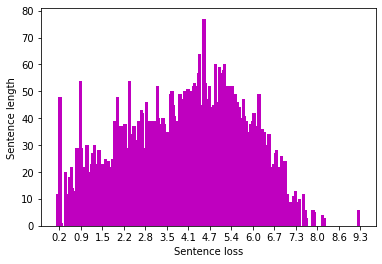

In [ ]:
# Histogram that shows how the length of the sentences in the test varies with respect to the associated loss

lengths = [tuple[-1] for tuple in sorted_tuples]
loss = [tuple[3] for tuple in sorted_tuples]

pos = np.linspace(loss[0], loss[-1], 15)
width = 0.1  
lens_ = np.linspace(loss[0], loss[-1], 15).tolist()
lens = ["{:.1f}".format(n) for n in lens_]

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(lens)
ax.set_xlabel(r'Sentence loss')
ax.set_ylabel(r'Sentence length')

plt.bar(loss, lengths, width, color='m')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[1.2628668606281281, 4.042672722838645, 4.754617631435394, 4.7452436946332455, 4.689029804120461, 4.660706026737507, 4.805224893523044, 4.729110197175907, 4.82877632856369, 4.634291247679637, 4.619146307309468, 4.489723921649986, 4.450233241833678, 4.503030318324849, 4.48573430418189, 4.616185925550909, 4.805877778566245, 4.610446559854701, 4.6874544431423315, 4.5952237571856775, 4.571715110582663, 4.581495661735534, 4.548211361798975, 4.547730464161488, 4.535211580732595, 4.607835248593362, 4.727936189953644, 4.458623421603236, 4.4563468000323505, 4.587072825147992, 4.722928605862518, 4.637911606479335, 4.547455474734306, 4.7206681655003475, 4.625062530690974, 4.665714706693377, 4.443122516978871, 4.54462447310939, 4.46839702129364, 4.594318548838298, 4.72617503007253, 4.856705599360996, 4.77259227808784, 4.922428982598441, 4.771134734153748, 4.329945683479309, 4.761226654052734, 3.5431721061468124, 4.90362674849374, 4.257231426239014, 4.5473809242248535, 4.751059859991074, 4.49531030

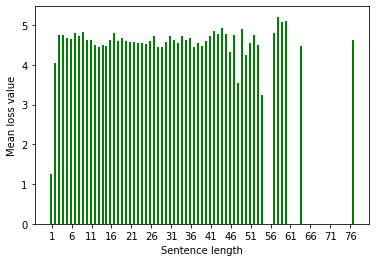

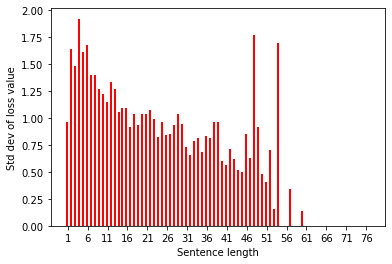

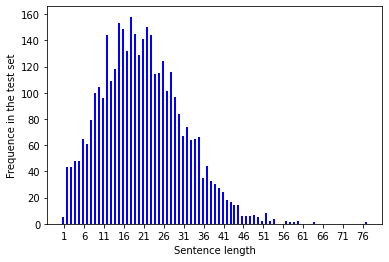

In [ ]:
loss_per_len = {i: [] for i in range(1, 78)}
for tuple in sorted_tuples:
  loss_per_len[tuple[-1]].append(tuple[3])

lengths = [i for i in range(1, 78)]
mean_per_len = [round(np.mean(loss_per_len[i]), 3) for i in lengths]
std_per_len = [round(np.std(loss_per_len[i]), 3) for i in lengths]
print(mean_per_len)
print(std_per_len)

# Histogram that shows the mean of the loss for each test sequence length

pos = np.arange(1, 81, 5)
width = 0.5  
lens = np.arange(1, 81, 5).tolist()

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(lens)
ax.set_xlabel(r'Sentence length')
ax.set_ylabel(r'Mean loss value')

plt.bar(lengths, mean_per_len, width, color='g')
plt.show()


# Histogram that shows the standard deviation of the loss for each test sentence length

pos = np.arange(1, 81, 5)
width = 0.5  
lens = np.arange(1, 81, 5).tolist()

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(lens)
ax.set_xlabel(r'Sentence length')
ax.set_ylabel(r'Std dev of loss value')

plt.bar(lengths, std_per_len, width, color='r')
plt.show()


# Histogram that shows the frequency distribution of length values in the test set  

lengths = list(range(1, 78))
frequencies = [0 for i in lengths]
for sent in test_sents:
  frequencies[len(sent)-1] += 1

pos = np.arange(1, len(lengths)+1, 5)
width = 0.5  
lens = list(range(1, 81, 5))

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(lens)
ax.set_xlabel(r'Sentence length')
ax.set_ylabel(r'Length frequence in the test set')

plt.bar(lengths, frequencies, width, color='b')
plt.show()


<br/>


Another check that can be performed is considering some of the words that appear most frequently in the **training set**, for example the 50 most frequent words, and compute the percentage of times they are **predicted correctly**, with respect to all the times they appear **in the targets**.

Ideally, the more frequently a word appeared during training, the more the model should be able to capture its influence and meaning in different contexts, and the higher should be the percentage of times it is predicted correctly at test time.

In order to verify this trend, I decided to plot the percentage of times some words were predicted correctly, when present in the **target sentences of the test set**. The analyzed words are the 50 most frequent words from the training data, considered in **descending order of frequency**. The expected behaviour of the histogram is that a higher **recall** in prediction should be associated to those words that appeared most frequently in the training set, since the model should be able to better capture their meaning and context of appearance. Indeed, a **general decreasing tendency** can be observed from the plot with the decrease of the words' frequencies, except for some outliers characterized by high recall values, although their appearance in the training set is more rare.







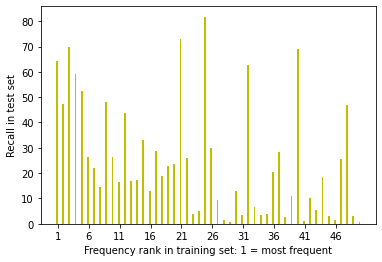

In [ ]:
recall = []

# For each word in the sorted dictionary of 50 most frequent words in the training set
for token in sorted_dict_train:

    # Number of appearances in the target set
    target_appearance = 0
    # Number of correct appearances in the predictions
    correct_prediction = 0

    # For each sentence in the target set
    for i in range(len(test_targets)):

        sent = test_targets[i]

        # For each word in the sentence
        for j in range(len(sent)):
            # If the word coincides with the considered token, update target_appearance
            if sent[j] == token:
                target_appearance += 1
                # If the word is correctly predicted, update correct_prediction
                if sent[j] == test_outputs[i][j]:
                    correct_prediction += 1

    # Update list of percentages
    recall.append(correct_prediction*100/target_appearance)
  

"""
The following histogram plots the RECALL value for the classes corresponding
to the 50 most frequent words in the training set, considered in decreasing order of frequency
""" 
frequencies = list(range(1, 51))
pos = np.arange(1, 51, 5)
width = 0.3  
lens = np.arange(1, 51, 5).tolist()

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(lens)
ax.set_xlabel(r'Frequency rank in training set: 1 = most frequent')
ax.set_ylabel(r'Recall in test set')

plt.bar(frequencies, recall, width, color='y')
plt.show()


<br/>

Another value that may be interesting to check is the **precision** in the test set corresponding to each of the 50 most frequent words of the training set. The precision corresponds to the percentage of times a certain word is **predicted correctly**, with respect to the number of times it appears **in the predictions**.

The computation can be performed in a similar way as it was done for the recall. In this case the plot does not show any meaningful trend.

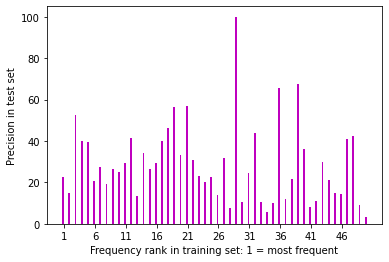

In [ ]:
precision = []

# For each word in the sorted dictionary of 50 most frequent words in the training set
for token in sorted_dict_train:

    # Number of appearances in the target set
    output_appearance = 0
    # Number of correct appearances in the predictions
    correct_prediction = 0

    # For each sentence in the output set
    for i in range(len(test_outputs)):

        sent = test_outputs[i]

        # For each word in the sentence
        for j in range(len(sent)):
            # If the word coincides with the considered token, update output_appearance
            if sent[j] == token:
                output_appearance += 1
                # If the word is correctly predicted, update correct_prediction
                if sent[j] == test_targets[i][j]:
                    correct_prediction += 1

    # Update list of percentages
    precision.append(correct_prediction*100/output_appearance)


"""
The following histogram plots the PRECISION value for the classes corresponding
to the 50 most frequent words in the training set, considered in decreasing order of frequency
""" 
frequencies = list(range(1, 51))
pos = np.arange(1, 51, 5)
width = 0.3  
lens = np.arange(1, 51, 5).tolist()

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(lens)
ax.set_xlabel(r'Frequency rank in training set: 1 = most frequent')
ax.set_ylabel(r'Precision in test set')

plt.bar(frequencies, precision, width, color='m')
plt.show()